## Importing libraries 

In [1]:
import os
import email
from email.policy import default
import tensorflow as tf
#import tensorflow_hub as hub
#import tensorflow_text
import os
import re
import pandas as pd
from tqdm import tqdm
import random 
import numpy as np 
import re
import mailbox
from bs4 import BeautifulSoup
from sklearn.metrics import confusion_matrix ,accuracy_score,\
precision_recall_fscore_support, classification_report 
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')


In [2]:
# checking for gpu 

!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1650 (UUID: GPU-d5d4886a-136f-2339-e88e-6e172ff13a68)


In [3]:
# installing packages
!pip freeze > kaggle_image_requirements.txt
!pip install tensorflow-text


## Getting phishing and ham data

In [4]:

def extract_message_bodies(text):
    # Split the text by the pattern that typically indicates the start of a new email
    messages = re.split(r'From r\s+', text)
    
    # Define a pattern to match the email headers which are typically followed by a blank line
    header_pattern = re.compile(r'(.*?)\n\n', re.DOTALL)
    
    phishing_messages_1 = []
    
    for message in messages:
        if not message.strip():
            continue
        
        # Find the header and remove it to get the body
        header_match = header_pattern.match(message)
        if header_match:
            body = message[header_match.end():].strip()
        else:
            # If no header match is found, treat the whole message as the body
            body = message.strip()
        
        phishing_messages_1.append(body)
    
    return phishing_messages_1


with open('./kaggle/input/fraudulent-email-corpus/fradulent_emails.txt',encoding='latin1') as f : 
    text=f.read()
# Extract message bodies
phishing_messages_1 = extract_message_bodies(text)

# Print the message bodies to verify
# for idx, body in enumerate(message_bodies):
#     print(f"Message {idx + 1} Body:\n{body}\n{'-'*50}\n")


In [5]:
print(f'{len(phishing_messages_1)} messages were extracted from file fradulent_emails.txt')

3976 messages were extracted from file fradulent_emails.txt


In [6]:
print('random message extracted from fradulent_emails.txt : \n','#'*100)
random.choice(phishing_messages_1)

random message extracted from fradulent_emails.txt : 
 ####################################################################################################


"This is a multi-part message in MIME format\n--6e025d4e-c21a-4c97-a625-315697e914c0\nContent-Type: text/plain; charset=iso-8859-1\nContent-Transfer-Encoding: quoted-printable\n\nDEAR SIR,\nI AM FORCED BY PREVAILING CIRCUMSTANCES TO WRITE YOU AND MAKE THIS \nPROPOSAL AT THE EXPENSE OF MY BEING EXPOSED;BUT I AM ENCOURAGED BECAUSE OF \nYOUR COUNTRY'S NON SUPPORT OF THE BRITISH/AMERICAN AGGRESSION AGAINST \nMY COUNTRY AND PEOPLE.\nI AM MR. SAAD ABDULRHMAN ALLI FROM AL-HUSSEINIA CITY IN IRAQ AND A SENIOR =\nMEMBER \nOF THE BATH PARTY IN IRAQ. I AM PRESENTLY TAKING REFUGE SOMEWHERE INSIDE \nSYRIA. I NEED YOUR HELP AND COOPERATION TO SECURE SOME FORTUNE \nDEPOSITED SOMEWHERE IN EUROPE BY US FOR SENIOR IRAQI OFFICIALS BEFORE THE WAR =\n\nIN MY COUNTRY AND I WILL DISCLOSE THE LOCATION OF THIS MONEY TO YOU AS \nWE PROGRESS.\nAFTER THE FIRST GULF WAR IN 1991, AMERICA BEGAN TO FREEZE ALL THE \nPERSONAL BANK ACCOUNTS OF SENIOR IRAQI OFFICIALS AND OUR LEADERS QUICKLY \nWITHDREW THEIR MONEY FROM WES

In [7]:
## getting ham data from email-spam-dataset-extended  dataset 

# Directory containing the email files
directory_ham = './kaggle/input/email-spam-dataset-extended/ham_zipped/main_ham'

# List to store the message bodies
ham_messages = []

# Function to extract the body from an email message
def extract_body(msg):
    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition"))

            # Skip attachments and just get the plain text part
            if "attachment" not in content_disposition:
                if content_type == "text/plain":
                    return part.get_payload(decode=True).decode(errors='replace')
    else:
        return msg.get_payload(decode=True).decode(errors='replace')

# Function to read file content in binary mode and decode it
def read_file_in_binary(file_path):
    with open(file_path, 'rb') as file:
        return file.read()

# Function to decode the binary content using different encodings
def decode_content(binary_content):
    encodings = ['utf-8', 'latin1', 'ascii']
    for enc in encodings:
        try:
            return binary_content.decode(enc)
        except UnicodeDecodeError:
            continue
    return binary_content.decode('latin1', errors='replace')  # fallback to 'latin1' with replacement

# Read all files in the directory
for filename in os.listdir(directory_ham):
    file_path = os.path.join(directory_ham, filename)
    
    # Read the file content in binary mode
    binary_content = read_file_in_binary(file_path)
    
    # Decode the binary content
    email_content = decode_content(binary_content)
    
    # Parse the email content
    msg = email.message_from_string(email_content, policy=default)
    
    # Extract the message body
    body = extract_body(msg)
    
    # Append the body to the list
    if body:
        ham_messages.append(body)

# Now message_bodies contains all the email message bodies
print(f'Total ham messages extracted: {len(ham_messages)} from email-spam-dataset-extended/ham_zipped/main_ham')


Total ham messages extracted: 6947 from email-spam-dataset-extended/ham_zipped/main_ham


In [8]:
print('a random message from ham messages extracted from email-spam-dataset-extended/ham_zipped/main_ham/ :\n','#'*100)
print(f'{random.choice(ham_messages)}')

a random message from ham messages extracted from email-spam-dataset-extended/ham_zipped/main_ham/ :
 ####################################################################################################
URL: http://www.aaronsw.com/weblog/000614
Date: 2002-09-24T11:03:09-06:00

I need a lawyer willing to argue that not-for-profit file sharing is fair use. 
I've got a plan. 

Napster: Work in Progress[1] -- that's new. They're also selling merchandise. 

MP3 Is Not a Crime[2] is a weblog covering the attacks on our rights. 

Dave Winer says he's not afraid to defend our rights[3]. _Yes! Who else?_ 

I will now refer to file sharing networks as "fair use networks"
like my limewire fair use network client.. or the kazaa fair use network..



[1] http://www.napster.com/
[2] http://www.mp3isnotacrime.org/
[3] http://scriptingnews.userland.com/backissues/2002/09/24#When:8:35:25AM





In [9]:

## getting phishing data from email-spam-dataset-extended 

# Directory containing the email files
directory_spam = './kaggle/input/email-spam-dataset-extended/spam_zipped/main_spam'

# List to store the message bodies
phishing_messages_2 = []

# Function to extract the body from an email message
def extract_body_from_spam(msg):
    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition"))

            # Skip attachments and just get the plain text part
            if "attachment" not in content_disposition:
                if content_type == "text/plain":
                    return part.get_payload(decode=True).decode(errors='replace')
    else:
        return msg.get_payload(decode=True).decode(errors='replace')

# Function to read file content in binary mode and decode it
def read_file_in_binary(file_path):
    with open(file_path, 'rb') as file:
        return file.read()

# Function to decode the binary content using different encodings
def decode_content(binary_content):
    encodings = ['utf-8', 'latin1', 'ascii']
    for enc in encodings:
        try:
            return binary_content.decode(enc)
        except UnicodeDecodeError:
            continue
    return binary_content.decode('latin1', errors='replace')  # fallback to 'latin1' with replacement

# Read all files in the directory
for filename in os.listdir(directory_spam):
    file_path = os.path.join(directory_spam, filename)
    
    # Read the file content in binary mode
    binary_content = read_file_in_binary(file_path)
    
    # Decode the binary content
    email_content = decode_content(binary_content)
    
    # Parse the email content
    msg = email.message_from_string(email_content, policy=default)
    
    # Extract the message body
    body = extract_body_from_spam(msg)
    
    # Append the body to the list
    if body:
        phishing_messages_2.append(body)

# Now message_bodies contains all the email message bodies
print(f'Total phishing messages extracted {len(phishing_messages_2)} from email-spam-dataset-extended/spam_zipped/main_spam')


Total phishing messages extracted 2293 from email-spam-dataset-extended/spam_zipped/main_spam


In [10]:
print('a random message from spam messages extracted from email-spam-dataset-extended/spam_zipped/main_spam/:\n','#'*100)
print(f'{random.choice(phishing_messages_2)}') 

a random message from spam messages extracted from email-spam-dataset-extended/spam_zipped/main_spam/:
 ####################################################################################################
iieo
<html>
<head>
<title>Mortgage companies make you wait</title>
</head>

<body>

<div align="center">
  <center>
  <table height="1" cellSpacing="0" width="540" border="0" style="border-collapse: collapse" bordercolor="#111111" cellpadding="0">
    <tr>
      <td colSpan="2">
      <p align="center"><font face="Tahoma" color="#008000"><big><strong>
      Mortgage companies make you wait...They Demand to Interview you...They <u>
      Intimidate</u> you...They <u>Humiliate</u> you...And All of That is While 
      They Decide If They Even Want to Do Business With You...</strong></big></p>
      <p align="center"><font color="#000000" size="5"><strong>We Turn the 
      Tables on Them...<br>
      Now, You're In Charge</strong></font></p>
      <p align="center"><font color="#000000"

In [11]:
## getting meassages from html like messages using beatiful soup 

def extract_message_body(message):
    soup = BeautifulSoup(message, 'html.parser')
    body = soup.get_text(separator='\n')
    return body.strip()

# List of messages
phishing_messages_3=[]
for ph_message in phishing_messages_2 : 
    phishing_messages_3.append(extract_message_body(ph_message))

In [12]:
print('a random phishing message from messages extracted from file in directory email-spam-dataset-extended/spam_zipped/main_spam:\n','#'*100)
print(f'{random.choice(phishing_messages_3)}')

a random phishing message from messages extracted from file in directory email-spam-dataset-extended/spam_zipped/main_spam:
 ####################################################################################################
BAD MSG:

PAM: -------------------- Start SpamAssassin results ----------------------
SPAM: This mail is probably spam.  The original message has been altered
SPAM: so you can recognise or block similar unwanted mail in future.
SPAM: See http://spamassassin.org/tag/ for more details.
SPAM: 
SPAM: Content analysis details:   (9.9 hits, 5 required)
SPAM: SEARCH_ENGINE_PROMO (2.6 points)  BODY: Discusses search engine listings
SPAM: HTML_50_70         (1.0 points)  BODY: Message is 50-70% HTML tags
SPAM: REALLY_UNSAFE_JAVASCRIPT (3.3 points)  BODY: Auto-executing JavaScript code
SPAM: SUPERLONG_LINE     (0.4 points)  BODY: Contains a line >=199 characters long
SPAM: CTYPE_JUST_HTML    (1.7 points)  HTML-only mail, with no text version
SPAM: PRIORITY_NO_NAME   (1.0 po

In [13]:
## getting data from phishingemaildetection dataset 

# Path to the mbox file
legal_emails_file = './kaggle/input/phishingemaildetection/emails-enron-legal-mails.mbox'

# List to store the message bodies
legal_emils = []

# Function to extract the body from an email message
def extract_body_from_legal(msg):
    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition"))

            # Skip attachments and just get the plain text part
            if "attachment" not in content_disposition:
                if content_type == "text/plain":
                    return part.get_payload(decode=True).decode('utf-8', errors='replace')
    else:
        return msg.get_payload(decode=True).decode('utf-8', errors='replace')

# Open the mbox file
mbox = mailbox.mbox(legal_emails_file)

# Iterate through each message in the mbox file
for msg in mbox:
    # Extract the message body
    body = extract_body_from_legal(msg)
    
    # Append the body to the list
    if body:
        legal_emils.append(body)

# Now message_bodies contains all the email message bodies
print(f'Total benign messages extracted from  emails-enron-legal-mails.mbox : {len(legal_emils)} message')



Total benign messages extracted from  emails-enron-legal-mails.mbox : 4279 message


In [14]:
# let's have a look on legal messages extracted from emails-enron-legal-mails.mbox
print('A random sample of benign messages exracted from  emails-enron-legal-mails.mbox:\n','-'*100)
for message in random.sample(legal_emils,2): 
    print(message,'\n\n\n','#'*100)


A random sample of benign messages exracted from  emails-enron-legal-mails.mbox:
 ----------------------------------------------------------------------------------------------------
The City League has once again revised our schedule.  Hopefully, this will be 
the last time.  In case you're wondering why we play the Jay Ballers, the 
team we beat last week, three times during the season and the Raiders only 
once, don't ask me.  The Raiders, however, are a much better team, so that 
should work to our advantage.  

Have a good weekend,
Brian


All games are on Wednesday nights at Jaycee Park ballfield
9/6 Bye
9/13 8pm vs. Jay Ballers (W 13-7)
9/20 7pm vs. Organized Confusion 
9/27 7pm vs. Raiders
10/4 7pm vs. Dawgs (Enron)
10/11 9pm vs. Jay Ballers
10/18 7pm vs. Jay Ballers 
10/25 9pm vs. Organized Confusion 
11/1 9pm vs. Dawgs (Enron)

Directions to Jaycee Park ballfield (NW)
1300 Seamist @ Grovewood
Go out the West Loop N (610) to W. 18th Street.
Exit W. 18th Steet, go right
Take ri

In [15]:
## cleaning legal_eamils list to get message bodies 

def clean_legal_email_body(email):
    # Remove forwarded or replied metadata
    email = re.sub(r'(--+ Forwarded by .* --+|--+ Original Message --+|--+ Reply Separator --+)', '', email, flags=re.IGNORECASE)
    # Remove email headers (To, From, Cc, etc.)
    email = re.sub(r'(^|\n)(From|To|Cc|Subject|Bcc):.*(\n|$)', '', email, flags=re.IGNORECASE)
    # Remove metadata that appears after the body
    email = re.sub(r'(\n\n.*(On .* wrote:|Sent from my .*|From: .*|Subject: .*|\[Quoted text hidden\]))', '', email, flags=re.IGNORECASE)
    # Remove leading and trailing whitespace
    email = email.strip()
    return email

def extract_and_clean_legal_emails(email_list):
    cleaned_bodies = []
    for email in email_list:
        cleaned_body = clean_legal_email_body(email)
        cleaned_bodies.append(cleaned_body)
    return cleaned_bodies

# creating a list of cleaned messages 
legal_emils_cleaned=extract_and_clean_legal_emails(legal_emils)

 > ##### legal_emils_cleaned is the final version of cleaned emails gotten from phishingemaildetection/emails-enron-legal-mails.mbox
 


In [16]:
# lets have a look on sample of cleaned legal emails extracted from emails-enron-legal-mails.mbox
print('A random sample of benign messages exracted from  emails-enron-legal-mails.mbox after cleaning :\n','-'*100)

for m in random.sample(legal_emils_cleaned,2): 
    print(m,'\n\n','#'*100)

A random sample of benign messages exracted from  emails-enron-legal-mails.mbox after cleaning :
 ----------------------------------------------------------------------------------------------------
Please find attached, the detail on the name change from ECR Energy, LLC to 
Northland Energy Trading, LLC

Short name changes on affected records will be coordinated with ERMS IT, 
tomorrow, Fri, 02/23.

Records on the Feb 2001 report will be inactivated next Thu, 03/01. 

 ####################################################################################################
<!doctype html public "-//w3c//dtd html 4.0 transitional//en"><html><HEAD>
<!--


You are receiving these e-reports because you have signed up for
CBS SportsLine.com Fantasy Football.  The default format for these
reports is HTML, however if you are reading this text your
mail reader is not displaying it as HTML.  To change to
text mode, or to customize, reschedule, or turn off these
reports please to to the URL below:



### Getting phishing emails from  emails-phishing-nazario.mbox

In [17]:

# Path to the mbox file
phishing_nazario_file_path = "./kaggle/input/phishingemaildetection/emails-phishing-nazario.mbox"

# Function to extract messages from mbox file
def extract_messages_from_mbox(mbox_file_path):
    messages = []
    mbox = mailbox.mbox(mbox_file_path)
    for message in mbox:
        messages.append(message)
    return messages

# Extract messages from mbox file
phishing_nazario_messages = extract_messages_from_mbox(phishing_nazario_file_path)

# Print the number of extracted messages
print(f"Number of phishing messages extracted from file phishingemaildetection/emails-phishing-nazario.mbox: {len(phishing_nazario_messages)} message")




Number of phishing messages extracted from file phishingemaildetection/emails-phishing-nazario.mbox: 2279 message


In [18]:
## removing messages that causes Unicodeerror 
import traceback
def clean_messages(messages):
    cleaned_messages = []
    for message in messages:
        try:
            # Attempt to decode and encode message to handle Unicode characters
            message_str = message.as_string()
            message_str.encode('utf-8')
            cleaned_messages.append(message)
        except UnicodeEncodeError:
            # If UnicodeEncodeError occurs, skip the message
#             traceback.print_exc()  # Print traceback to debug the error
            continue
    return cleaned_messages

# Clean the phishing_nazario_messages list
cleaned_phishing_nazario_messages = clean_messages(phishing_nazario_messages)
print(f'removed {len(phishing_nazario_messages)-len(cleaned_phishing_nazario_messages)} messages that cause Unicodeerror')


removed 141 messages that cause Unicodeerror


In [19]:
print(f'{len(cleaned_phishing_nazario_messages)} phishing messages remains after removing message that cause Unicodeerror' )

2138 phishing messages remains after removing message that cause Unicodeerror


In [20]:
# let's have a look on sample of cleaned_phishing_nazario_messages
print('A random sample of phishing messages exracted from  file phishingemaildetection/emails-phishing-nazario.mbox \
after removing message that cause Unicodeerror :\n','-'*100)

for m in random.sample(cleaned_phishing_nazario_messages,1):
    print(m,'\n\n')

A random sample of phishing messages exracted from  file phishingemaildetection/emails-phishing-nazario.mbox after removing message that cause Unicodeerror :
 ----------------------------------------------------------------------------------------------------
Return-Path: <user@mail.example.com>
Delivered-To: user@example.com
Received: from mail.example.com (mail.example.com [192.168.6.4])
	by example.com (Postfix) with ESMTP id 9340B2A898
	for <user@example.com>; Thu, 19 Jan 2006 13:45:31 -0500 (EST)
Received: by mail.example.com (Example mail relay)
	id 4A52A621CB2; Thu, 19 Jan 2006 13:45:31 -0500 (EST)
Delivered-To: user@example.com
Received: from mail.example.com (mail.example.com [192.168.3.6])
	by mail.example.com (Example mail relay) with ESMTP id 2ED64621CA5
	for <user@example.com>; Thu, 19 Jan 2006 13:45:31 -0500 (EST)
Received: (from user@localhost)
	by mail.example.com id NAA00442
	for user@example.com; Thu, 19 Jan 2006 13:45:31 -0500
Received: from hoss (cpe-67-10-248-48.ho

> ##### cleaned_phishing_nazario_messages is like html so we have to get text from it 

In [21]:
# getting text from html for cleaned_phishing_nazario_messages
def extract_phishing_text_from_html(html_content):
    # Convert bytes-like object to string if necessary
    if isinstance(html_content, bytes):
        html_content = html_content.decode('utf-8')
    
    soup = BeautifulSoup(html_content, 'html.parser')
    text = soup.get_text(separator='\n')
    # Remove the long, seemingly random text at the end
    if '*******' in text:
        text = text.split('*******')[0]
    return text

def extract_text_from_payload(payload):
    if isinstance(payload, str):
        return payload
    elif isinstance(payload, bytes):
        return payload.decode('utf-8')
    elif isinstance(payload, list):
        text = ''
        for part in payload:
            text += extract_text_from_payload(part)
        return text
    elif isinstance(payload, email.message.Message):
        return extract_text_from_payload(payload.get_payload())
    else:
        return ''

# Extract text from HTML content
cleaned_phishing_nazario_messages_text = []
for message in cleaned_phishing_nazario_messages:
    if isinstance(message, email.message.Message):
        html_content = extract_text_from_payload(message)
        if html_content:
            extracted_text = extract_phishing_text_from_html(html_content)
            cleaned_phishing_nazario_messages_text.append(extracted_text)



In [22]:
# let's have a look on sample of cleaned_phishing_nazario_messages_text 
print('A random sample of phishing messages exracted from  file phishingemaildetection/emails-phishing-nazario.mbox \
after extracting messages from html format and cleaning message body :\n','='*100)

for m in random.sample(cleaned_phishing_nazario_messages_text,1):
    print(m,'\n\n')

A random sample of phishing messages exracted from  file phishingemaildetection/emails-phishing-nazario.mbox after extracting messages from html format and cleaning message body :










New Page 1
























































 Security Center
Advisory!




 We recently noticed one or more attempts to log in to your PayPal
account from a 



foreign IP address and we have reasons to belive that your account was
hijacked 



by a third party without your authorization. If you recently accessed your
account while traveling, the unusual log in 
attempts



may have been initiated by you.


If you are the rightful holder of the account you must 
click the
link below
 and then complete all steps from 
the following page as we try to verify your identity.
















Click here to verify your 
account
If
you choose to ignore our request, you 
leave us no choise but to temporaly suspend 



your account.
Thank you for using PayPal! The PayPal Team













In [23]:
## removing long bad text that is longer than 25 words 
def remove_long_words(messages):
    cleaned_messages = []
    for message in messages:
        words = message.split()
        cleaned_words = [word for word in words if len(word) <= 25]
        cleaned_message = ' '.join(cleaned_words)
        cleaned_messages.append(cleaned_message)
    return cleaned_messages


cleaned_phishing_nazario_messages_text_1 = remove_long_words(cleaned_phishing_nazario_messages_text)



In [24]:
# to find if the long text was removed or not 
cleaned_phishing_nazario_messages_text_1[:5]

['in 1841 stars battle Tour de France in 1872 in 1923',
 'Dear eBay User , After fraud complaints from the eBay members, the eBay Inc. had developed a security program against the fraudulend attempts of accounts thefts. For that we have to securise all the members informations by updating and checking the registrated informations. Please update your information by completing the form from the forwarded link so we can check your account validity and your identity and login to eBay in order to update your informations. This process will take 5 days, period when you will not be able to acces your eBay account. After this period you will receive instructions to enter and securise your eBay account.Please click the link below and sign in into your account: -- As outlined in our User Agreement, eBay will periodically send you information about site changes and enhancements. Visit our Privacy Policy and User Agreement if you have any questions. Regards,Safeharbor Department eBay, Inc.',
 "Dea

## Getting all data into a dataframe 

In [25]:
## making a dataframe from ham messages 
all_ham_messages=ham_messages+legal_emils_cleaned#+ham_messages_2100
ham_df=pd.DataFrame({'phishing':[0]*len(all_ham_messages),'text':all_ham_messages})
ham_df

,phishing,text
0,0,"Date: Tue, 20 Aug 2002 17:27:47 -05..."
1,0,"Date: Wed, 21 Aug 2002 10:54:46 -05..."
2,0,\n======================== THE MOTLEY FOOL ===...
3,0,> From: Valdis.Kletnieks@vt.edu\n> Date: Wed...
4,0,"Martin A posted:\nTassos Papadopoulos, the Gre..."
...,...,...
11221,0,Fly me to the moon.
11222,0,Here is order:\n\nhttp://cips.ferc.fed.us/Q/CI...
11223,0,This is really good.\n\n----------------------...
11224,0,That actually made me cry.\n\nSusan


In [26]:
## making a dataframe from phishing data
all_phishing_data=phishing_messages_1+phishing_messages_3+cleaned_phishing_nazario_messages_text_1
phishing_df=pd.DataFrame({'phishing':[1]*len(all_phishing_data),'text':all_phishing_data})
phishing_df

,phishing,text
0,1,FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...
1,1,"Dear Friend,\n\nI am Mr. Ben Suleman a custom ..."
2,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
3,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
4,1,"Dear sir, \n \nIt is with a heart full of hope..."
...,...,...
8402,1,"Dear PayPal Member, Your account has been rand..."
8403,1,Web-Based Email :: View :: eBay sent this mess...
8404,1,"Dear eBay user, eBay Customer Support Team req..."
8405,1,"Dear PayPal Member, Your account has been rand..."


In [27]:
## concatinating ham and phishing into a dataframe 
data=pd.concat([phishing_df,ham_df],axis=0)
data

,phishing,text
0,1,FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...
1,1,"Dear Friend,\n\nI am Mr. Ben Suleman a custom ..."
2,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
3,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
4,1,"Dear sir, \n \nIt is with a heart full of hope..."
...,...,...
11221,0,Fly me to the moon.
11222,0,Here is order:\n\nhttp://cips.ferc.fed.us/Q/CI...
11223,0,This is really good.\n\n----------------------...
11224,0,That actually made me cry.\n\nSusan


In [28]:
# shuffling data to ensure that the splits are representative of the whole dataset.
shuffled_df=data.sample(frac=1,random_state=42)
shuffled_df

,phishing,text
7139,0,Tana:\n\nNone of the CPs on today's list are a...
4740,1,Commentary\n\n\n\nIt is time to refinance!\n\n...
2221,1,"FROM MRS. JOCELYN MOMODU.\nNO 102 16TH STREET,..."
10264,0,Vince\n\nThanks for the update - especially yo...
5968,0,I'm getting these messages and I'm not sure wh...
...,...,...
2877,0,"Matthias,\n\nOn Mon, Sep 30, 2002 at 09:28:26A..."
3557,0,> I suggest that you use a normal user to star...
5390,1,GT TONER\nSUPPLIES\nLaser printer and computer...
860,1,FROM:TSEPO VUSI\n\nEMAIL_tsepovusi@netscape.ne...


In [29]:
## checking for balance of data 
shuffled_df['phishing'].value_counts()

phishing
0    11226
1     8407
Name: count, dtype: int64

In [30]:
shuffled_df.isna().sum()

phishing    0
text        0
dtype: int64

In [31]:
## checking for duplicates 
shuffled_df.duplicated().sum()

4632

In [32]:
## duplicates in phishing class 
duplicated_phishing=shuffled_df[shuffled_df['phishing']==1].duplicated().sum()
print(f'there is {duplicated_phishing} duplicated phishing messages in data ')

there is 1935 duplicated phishing messages in data 


In [33]:
## number of duplicates in non-phishing  class 

duplicated_ham=shuffled_df[shuffled_df['phishing']==0].duplicated().sum()
print(f'there is {duplicated_ham} duplicated ham messages in data ')

there is 2697 duplicated ham messages in data 


In [34]:
## removing duplicates 
shuffled_df=shuffled_df.drop_duplicates()


In [35]:
# counting classes in data after remvoing duplicates 

num_phishing_messages=len(shuffled_df[shuffled_df['phishing']==1])
num_ham_messages=len(shuffled_df[shuffled_df['phishing']==0])
print(f'there is {num_phishing_messages} phishing messages and {num_ham_messages} ham messages in data after removing Duplicates')

there is 6472 phishing messages and 8529 ham messages in data after removing Duplicates


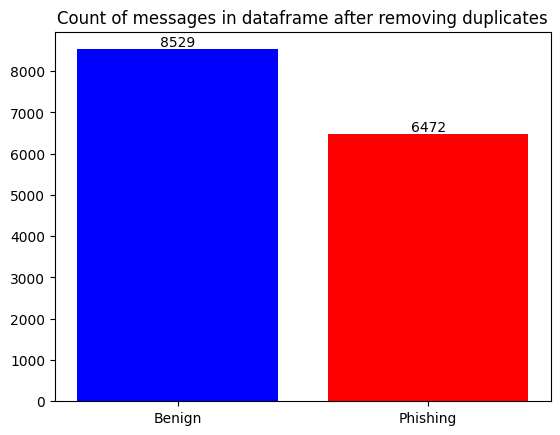

In [36]:
import matplotlib.pyplot as plt

counts = shuffled_df['phishing'].value_counts().values
categories = ['Benign', 'Phishing']

# Create the bar plot
plt.bar(categories, counts, color=['blue', 'red'])

# Add text above the bars
for i, count in enumerate(counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom')

# Set the title of the plot
plt.title('Count of messages in dataframe after removing duplicates')

# Display the plot
plt.show()


In [37]:
# saving extracted data to csv file 
shuffled_df.to_csv('extracted_data.csv', index=False, escapechar='\\')


## splitting data to train and test 


In [38]:
shuffled_df
## for column phishing  1 means phishing and 0 means legitimate (legal or ham) messages 

,phishing,text
7139,0,Tana:\n\nNone of the CPs on today's list are a...
4740,1,Commentary\n\n\n\nIt is time to refinance!\n\n...
2221,1,"FROM MRS. JOCELYN MOMODU.\nNO 102 16TH STREET,..."
10264,0,Vince\n\nThanks for the update - especially yo...
5968,0,I'm getting these messages and I'm not sure wh...
...,...,...
769,1,From:Cyril Konan.\nAbidjan Cote D'Ivoire.\nTel...
1685,1,"Gooday, \n\nI am Mr Olsom Berghart a personal ..."
7616,0,"Michelle,\nI agree with you that we need to ru..."
8443,0,One of your friends sent this email through ou...


In [39]:
# splitting data into 80% train and 20% test data 
from sklearn.model_selection import train_test_split 
train_text,test_text,train_labels,test_labels=train_test_split(shuffled_df['text'],
                                                               shuffled_df['phishing'],
                                                               random_state=42,test_size=.2)

In [40]:
# counting classes in train data to check for balance 
train_labels.value_counts()

phishing
0    6831
1    5169
Name: count, dtype: int64

In [41]:
print(f'total messages in trian data are {len(train_labels)} message')


total messages in trian data are 12000 message


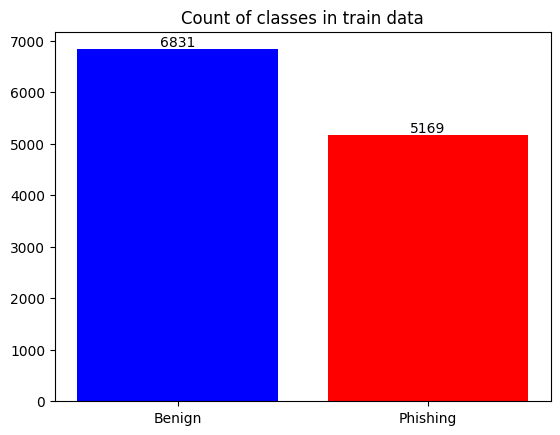

In [42]:
train_counts = train_labels.value_counts().values
categories = ['Benign', 'Phishing']

# Create the bar plot
plt.bar(categories, train_counts, color=['blue', 'red'])

# Add text above the bars
for i, count in enumerate(train_counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom')

# Set the title of the plot
plt.title('Count of classes in train data')

# Display the plot
plt.show()


In [43]:
print(f'total messages in test data are {len(test_labels)} message')


total messages in test data are 3001 message


In [44]:
# counting classes in test data to check for balance 

print(test_labels.value_counts())


phishing
0    1698
1    1303
Name: count, dtype: int64


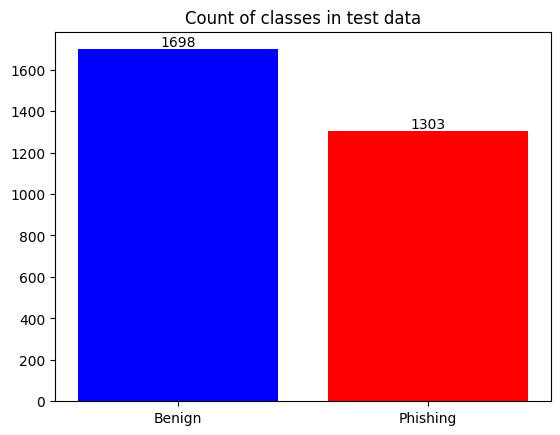

In [45]:
test_counts = test_labels.value_counts().values
categories = ['Benign', 'Phishing']

# Create the bar plot
plt.bar(categories, test_counts, color=['blue', 'red'])

# Add text above the bars
for i, count in enumerate(test_counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom')

# Set the title of the plot
plt.title('Count of classes in test data')

# Display the plot
plt.show()


In [46]:
## defining a function for calculating metrics 
from sklearn.metrics import confusion_matrix ,accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) 
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [47]:
## lets have a look at messages length (number of words in each message)
messages_length=[]
# find length of every message 
for index,label,message in shuffled_df.itertuples() : 
    messages_length.append(len(message.split(' ')))
random.sample(messages_length,25)    
    

[2,
 142,
 247,
 49,
 47,
 295,
 16,
 578,
 532,
 298,
 170,
 155,
 119,
 429,
 79,
 337,
 235,
 414,
 87,
 49,
 1139,
 945,
 43,
 99,
 334]

In [48]:
print(f'longest message in data  has {max(messages_length)} words')
# finding what value that 95% of lengths of messages are below it 
l=round(np.percentile(messages_length,95))
print(f'length of 95% of messages is less than {l} words')

longest message in data  has 36351 words
length of 95% of messages is less than 1060 words


 >* as length of 95% of messages is less than 1081 words  we can take output_sequence_length as 1024 or 512 so our model is going to see only first 1024 words of every message  
 >* we will take  max_tokens=20000 so our model is going to take most frequent 20000 words 

In [49]:
## making Text vectorization layer 
from keras import layers  
text_vectorizer=layers.TextVectorization(max_tokens=20000,output_mode='int',output_sequence_length=1024,name='text_vectorization')

In [50]:
import re
# cleaning text to get rid of error causing characters -> later fix!!!!!!!!
train_text = [re.sub(r'[^\x00-\x7F]+', '', text) for text in train_text]

In [51]:
# adapting text vectorizer on train data 
text_vectorizer.adapt(train_text)

In [52]:
# getting a list of words in the train data 
words_in_vocab=text_vectorizer.get_vocabulary()

In [53]:
print('most common 20 words are : \n')
words_in_vocab[:20]

most common 20 words are : 



['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'in',
 'you',
 'i',
 'for',
 'this',
 'is',
 'your',
 'that',
 'will',
 'on',
 'with',
 'as',
 'be']

In [54]:
print('most uncommon 20 words are : \n')
words_in_vocab[-20:]
## we are going to keep numbers in data as For tasks like spam detection, numbers could be significant.
# For example, spam messages often contain phone numbers, prices, or promotional codes.

most uncommon 20 words are : 



['administered',
 'adjective',
 'adjacent',
 'acuse',
 'activar',
 'activacion',
 'accountthis',
 'accountnbsp',
 'accountants',
 'accountae',
 'account2ei',
 'accomplishments',
 'accompanying',
 'abuses',
 'absurd',
 'abound',
 'aboriginal',
 'abilities',
 'abidjanthe',
 'abdalla']

In [55]:
# testing text vectorizer for a sentence 
sentence='i am happy today . i am going to have a vacancy . '
text_vectorizer([sentence])

<tf.Tensor: shape=(1, 1024), dtype=int64, numpy=array([[   9,   41, 1103, ...,    0,    0,    0]], dtype=int64)>

### Creating an Embedding using an Embedding Layer


In [56]:
# creating an embedding layer with sequence length 1024  words and  sees most common 200000 words 
embed=layers.Embedding(input_dim=20000,output_dim=128,input_length=1024,name='Embedding_Name-123')

In [57]:
# testing embedding layer for a sentence 
embed(text_vectorizer([sentence]))

<tf.Tensor: shape=(1, 1024, 128), dtype=float32, numpy=
array([[[ 0.0389653 , -0.04470611, -0.04018826, ...,  0.00489759,
         -0.04018829, -0.01233361],
        [ 0.04420573, -0.02424493,  0.04608481, ...,  0.01382181,
         -0.04038984, -0.00220492],
        [-0.02300065,  0.01888256,  0.01529903, ..., -0.01466682,
         -0.04036112, -0.04810631],
        ...,
        [ 0.02489002, -0.01376269, -0.04703109, ...,  0.03073266,
          0.02691295,  0.03564215],
        [ 0.02489002, -0.01376269, -0.04703109, ...,  0.03073266,
          0.02691295,  0.03564215],
        [ 0.02489002, -0.01376269, -0.04703109, ...,  0.03073266,
          0.02691295,  0.03564215]]], dtype=float32)>

## Satrting Experiments 

In [58]:
## creating functions for callbacks 

# function to create a checkpoint callback 
def create_checkpoint_callback(file_path):
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path,  # Path to save the model
    save_weights_only=False,  # Set to True if you only want to save the model weights
    save_best_only=True,  # Set to True to save only the best model based on a monitored metric
    monitor='val_loss',  # Metric to monitor
    mode='auto',  # Mode for monitoring the metric (auto, min, max)
    save_freq='epoch'  # Frequency to save the model ('epoch' or integer steps)
    )
    return model_checkpoint_callback
# function to create a tensorboard callback 
def create_tensorboard_callback(file_path):
    tensorboard=tf.keras.callbacks.TensorBoard(log_dir=file_path)
    return    tensorboard
    

# ah shit here we go again

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'a' is the feature set and 'train_labels' is the target variable
X = a
y = train_labels

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(train_text, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras

# Define the model
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=1024, name='input_layer'),
    keras.layers.Dense(40, name='hidden_1'),
    keras.layers.Lambda(lambda x: x * x, name='lambda_layer'),
    keras.layers.Dense(20, name='hidden_2'),
    keras.layers.Dense(10, name='hidden_3'),
    keras.layers.Dense(1,activation='sigmoid', name='output_layer') #keras.layers.Dense(2,activation='sigmoid', name='output_layer')
])


# Compile the model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

# Summary of the model
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_1 (Dense)            (None, 40)                41000     
                                                                 
 lambda_layer (Lambda)       (None, 40)                0         
                                                                 
 hidden_2 (Dense)            (None, 20)                820       
                                                                 
 hidden_3 (Dense)            (None, 10)                210       
                                                                 
 output_layer (Dense)        (None, 1)                 11        
                                                                 
Total params: 42,041
Trainable params: 42,041
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Define the model
model = Sequential()
model.add(Dense(100, input_dim=1024, activation='linear'))
model.add(Dropout(0.5))
model.add(Dense(80, activation='linear'))
model.add(Dropout(0.5))
model.add(Dense(60, activation='linear'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='linear'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='linear'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='linear'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='linear'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='linear'))
model.add(Dropout(0.5))
model.add(Dense(31, activation='linear'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='linear'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

# Summary of the model
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 100)               102500    
                                                                 
 dropout_28 (Dropout)        (None, 100)               0         
                                                                 
 dense_89 (Dense)            (None, 80)                8080      
                                                                 
 dropout_29 (Dropout)        (None, 80)                0         
                                                                 
 dense_90 (Dense)            (None, 60)                4860      
                                                                 
 dropout_30 (Dropout)        (None, 60)                0         
                                                                 
 dense_91 (Dense)            (None, 50)              

In [63]:
a = text_vectorizer(np.array(train_text))

In [100]:
# run the model
model.fit(a, train_labels, epochs=50, batch_size=64, verbose=1)

Epoch 1/50
188/188 [==============================] - 2s 6ms/step - loss: 4069.7061 - accuracy: 0.5161
Epoch 2/50
188/188 [==============================] - 1s 6ms/step - loss: 241.0744 - accuracy: 0.5043
Epoch 3/50
188/188 [==============================] - 1s 5ms/step - loss: 42.9074 - accuracy: 0.5037
Epoch 4/50
188/188 [==============================] - 1s 6ms/step - loss: 39.4438 - accuracy: 0.5008
Epoch 5/50
188/188 [==============================] - 1s 5ms/step - loss: 37.6499 - accuracy: 0.5034
Epoch 6/50
188/188 [==============================] - 1s 6ms/step - loss: 34.4500 - accuracy: 0.5085
Epoch 7/50
188/188 [==============================] - 1s 5ms/step - loss: 32.3557 - accuracy: 0.5061
Epoch 8/50
188/188 [==============================] - 1s 5ms/step - loss: 29.6444 - accuracy: 0.5142
Epoch 9/50
188/188 [==============================] - 1s 5ms/step - loss: 33.0526 - accuracy: 0.5103
Epoch 10/50
188/188 [==============================] - 1s 6ms/step - loss: 29.2454 - acc

In [ ]:
model.evaluate(text_vectorizer(np.array(test_text)), test_labels, )

94/94 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6578


[0.6543885469436646, 0.6577807664871216]

# SK LEARN LINEAR REGRESSION

In [95]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'a' is the feature set and 'train_labels' is the target variable
X = a
y = train_labels

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([ 9182, 11091,  6428, ...,  5390,   860,  7270])

## Long-Term Short Memory (LSTM) model  

In [59]:
#import tensorflow as tf 
#inputs=layers.Input(shape=(1,),dtype=tf.string)
#x=text_vectorizer(inputs)
#x=embed(x)
#x=layers.LSTM(64,activation='tanh',name='lstm_layer',return_sequences=True)(x)
#x=layers.Dense(32,activation='relu')(x)
#outputs=layers.Dense(1,activation='sigmoid')(x)
#lstm_model_1=tf.keras.Model(inputs,outputs,name='lstm_model_1')
#lstm_model_1.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

import tensorflow as tf
from tensorflow.keras import layers

# Input layer for string input
inputs = layers.Input(shape=(1,), dtype=tf.string)

# Text vectorization and embedding layers
x = text_vectorizer(inputs)
x = embed(x)

# LSTM layer with `return_sequences=False` for single output
x = layers.LSTM(64, activation='tanh', name='lstm_layer', return_sequences=False)(x)

# Dense layers for binary classification
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

# Model definition
lstm_model_1 = tf.keras.Model(inputs, outputs, name='lstm_model_1')

# Compile the model
lstm_model_1.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')


#### creating tensorboard , early stopping and checkpoint callpacks 

In [60]:
lstm_1_checkpoint_callback = create_checkpoint_callback(file_path='checkpoints/lstm_1_checkpoint')

lstm_tensorboard=create_tensorboard_callback(file_path='logs/lstm_1')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Verbosity mode (0, 1, or 2)
    mode='max',  # Mode for monitoring the metric ('min', 'max', or 'auto')
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)


In [61]:
# another fix -__-
import numpy as np

train_text = np.array(train_text)
train_labels = np.array(train_labels)
test_text = np.array(test_text)
test_labels = np.array(test_labels)


In [62]:
#print dimensions of train and test data
print(f'train text shape : {train_text.shape}')
print(f'train labels shape : {train_labels.shape}')
print(f'test text shape : {test_text.shape}')
print(f'test labels shape : {test_labels.shape}')



train text shape : (12000,)
train labels shape : (12000,)
test text shape : (3001,)
test labels shape : (3001,)


In [63]:
# training lstm_model_1 
lstm_1_history = lstm_model_1.fit(train_text,train_labels, epochs=50, validation_data=(test_text, test_labels),
                                   callbacks=[lstm_1_checkpoint_callback, lstm_tensorboard, early_stopping_callback])
# check if hf5 format error occurs: https://github.com/keras-team/tf-keras/issues/574
# removed .keras file extension to get rid of error.. 

Epoch 1/50
375/375 [==============================] - ETA: 0s - loss: 0.6791 - accuracy: 0.5718

INFO:tensorflow:Assets written to: checkpoints\lstm_1_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoints\lstm_1_checkpoint\assets


375/375 [==============================] - 77s 177ms/step - loss: 0.6791 - accuracy: 0.5718 - val_loss: 0.6784 - val_accuracy: 0.5721
Epoch 2/50
375/375 [==============================] - 54s 144ms/step - loss: 0.6565 - accuracy: 0.5870 - val_loss: 0.6957 - val_accuracy: 0.5661
Epoch 3/50
375/375 [==============================] - ETA: 0s - loss: 0.6551 - accuracy: 0.5867

INFO:tensorflow:Assets written to: checkpoints\lstm_1_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoints\lstm_1_checkpoint\assets


375/375 [==============================] - 61s 163ms/step - loss: 0.6551 - accuracy: 0.5867 - val_loss: 0.6698 - val_accuracy: 0.5781
Epoch 4/50
375/375 [==============================] - 68s 181ms/step - loss: 0.6869 - accuracy: 0.5797 - val_loss: 0.6777 - val_accuracy: 0.5658
Epoch 5/50
375/375 [==============================] - ETA: 0s - loss: 0.6604 - accuracy: 0.5875

INFO:tensorflow:Assets written to: checkpoints\lstm_1_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoints\lstm_1_checkpoint\assets


375/375 [==============================] - 79s 211ms/step - loss: 0.6604 - accuracy: 0.5875 - val_loss: 0.6667 - val_accuracy: 0.5881
Epoch 6/50
375/375 [==============================] - ETA: 0s - loss: 0.5222 - accuracy: 0.7640

INFO:tensorflow:Assets written to: checkpoints\lstm_1_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoints\lstm_1_checkpoint\assets


375/375 [==============================] - 84s 224ms/step - loss: 0.5222 - accuracy: 0.7640 - val_loss: 0.5248 - val_accuracy: 0.7781
Epoch 7/50
375/375 [==============================] - ETA: 0s - loss: 0.4822 - accuracy: 0.7995

INFO:tensorflow:Assets written to: checkpoints\lstm_1_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoints\lstm_1_checkpoint\assets


375/375 [==============================] - 75s 199ms/step - loss: 0.4822 - accuracy: 0.7995 - val_loss: 0.4870 - val_accuracy: 0.8071
Epoch 8/50
375/375 [==============================] - ETA: 0s - loss: 0.4606 - accuracy: 0.8161

INFO:tensorflow:Assets written to: checkpoints\lstm_1_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoints\lstm_1_checkpoint\assets


375/375 [==============================] - 78s 207ms/step - loss: 0.4606 - accuracy: 0.8161 - val_loss: 0.4823 - val_accuracy: 0.8124
Epoch 9/50
375/375 [==============================] - 62s 164ms/step - loss: 0.4752 - accuracy: 0.7991 - val_loss: 0.6677 - val_accuracy: 0.5788
Epoch 10/50
375/375 [==============================] - 62s 165ms/step - loss: 0.6539 - accuracy: 0.5821 - val_loss: 0.6725 - val_accuracy: 0.5798
Epoch 11/50
375/375 [==============================] - 69s 185ms/step - loss: 0.6527 - accuracy: 0.5838 - val_loss: 0.6704 - val_accuracy: 0.5795
Epoch 12/50
375/375 [==============================] - 62s 167ms/step - loss: 0.5329 - accuracy: 0.7511 - val_loss: 0.5340 - val_accuracy: 0.7777
Epoch 13/50
375/375 [==============================] - 60s 161ms/step - loss: 0.5200 - accuracy: 0.7566 - val_loss: 0.6758 - val_accuracy: 0.5768
Epoch 14/50
375/375 [==============================] - 59s 158ms/step - loss: 0.5107 - accuracy: 0.7738 - val_loss: 0.5629 - val_accuracy

In [64]:

lstm_model_1.summary()

Model: "lstm_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 1024)             0         
 torization)                                                     
                                                                 
 Embedding_Name-123 (Embeddi  (None, 1024, 128)        2560000   
 ng)                                                             
                                                                 
 lstm_layer (LSTM)           (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                

In [65]:
# craeting function to plot training curves 
def plot_loss_and_accuracy_curves(model_history):
    epochs = range(len(model_history.history['loss']))
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    accuracy = model_history.history['accuracy']
    val_accuracy = model_history.history['val_accuracy']
    
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


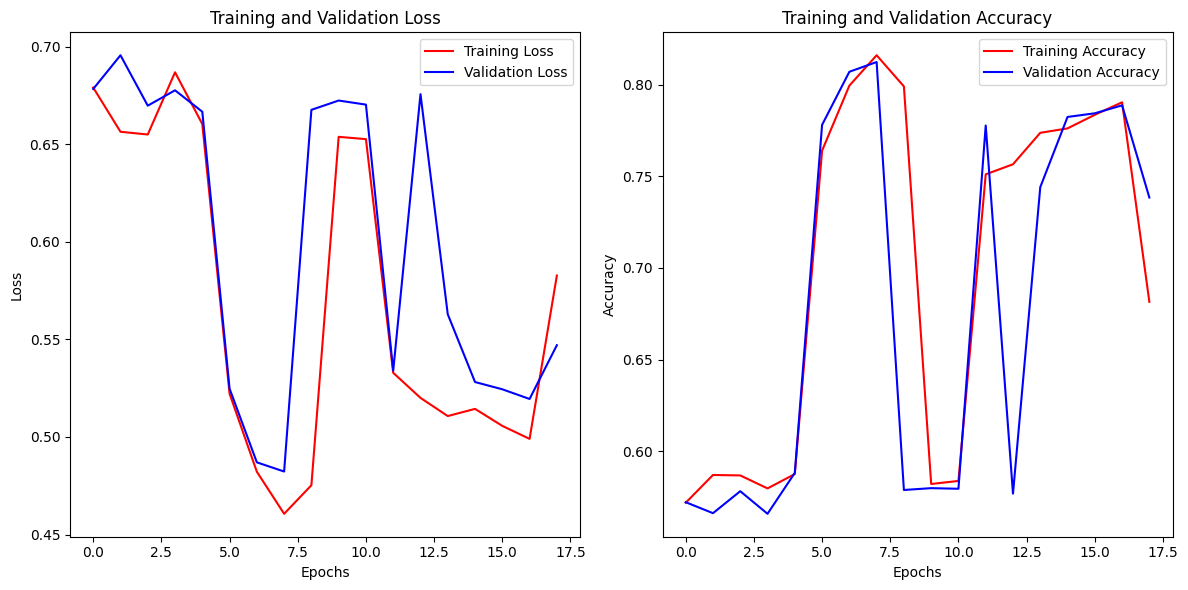

In [66]:
# plotting training curves for lsmt_model_1

plot_loss_and_accuracy_curves(lstm_1_history)

### Evaluating lstm_model_1

In [67]:
## calculating metrics for model 
pred_labels_lstm1=lstm_model_1.predict(test_text)
pred_labels_lstm1.shape

94/94 [==============================] - 9s 86ms/step


(3001, 1)

In [69]:
import seaborn as sns
# creating function to plot confusion matrix 
def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, class_names: list = ["ham", "Phishing"]) -> None:
    """
    Plots a confusion matrix for binary classification.

    Parameters:
    y_true (np.ndarray): Ground truth (correct) target values.
    y_pred (np.ndarray): Estimated targets as returned by a classifier.
    class_names (list): List of class names. Default is ["Negative", "Positive"].
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


In [70]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
# function to calculate other important metrics
def calculate_metrics(y_true, y_pred):
    """
    Calculate various classification metrics using scikit-learn.

    Args:
        y_true (list or np.array): The true labels.
        y_pred (list or np.array): The predicted labels.

    Returns:
        dict: A dictionary containing the calculated metrics.

    Note:
        - The function assumes binary classification (0 and 1 labels).
        - The true labels and predicted labels should be of the same length.
    """
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate metrics
    FDR = fp / (tp + fp) if (tp + fp) != 0 else 0  # False Discovery Rate
    FNR = fn / (tp + fn) if (tp + fn) != 0 else 0  # False Negative Rate
    FOR = fn / (fn + tn) if (fn + tn) != 0 else 0  # False Omission Rate
    FPR = fp / (fp + tn) if (fp + tn) != 0 else 0  # False Positive Rate
    NPV = tn / (tn + fn) if (tn + fn) != 0 else 0  # Negative Prediction Value
    

    metrics = {
        'False Discovery Rate (FDR)': FDR,
        'False Negative Rate (FNR)': FNR ,
        'False Omission Rate (FOR)': FOR,
        'False Positive Rate (FPR)': FPR,
        'Negative Prediction Value (NPV)': NPV
        
    }

    return metrics

In [71]:
# Average over the time steps
avg_pred_labels_lstm1 = np.mean(pred_labels_lstm1, axis=1)

avg_pred_labels_lstm1.flatten().shape
avg_pred_labels_lstm1=np.round(avg_pred_labels_lstm1.flatten())

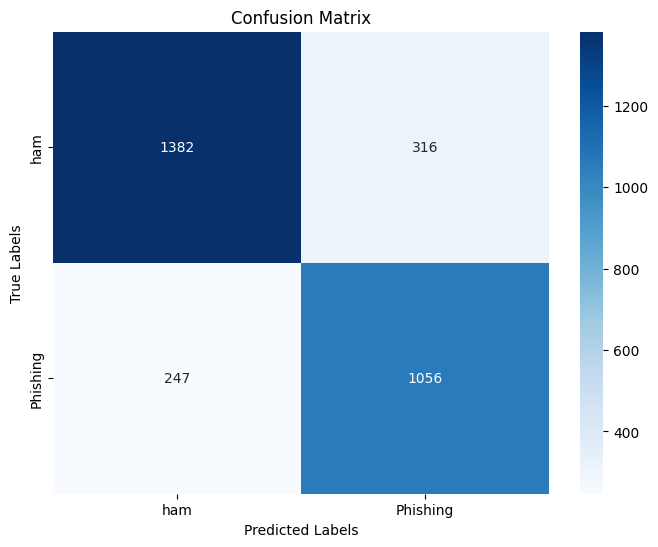

In [73]:
plot_confusion_matrix(y_pred=avg_pred_labels_lstm1,y_true=test_labels)

In [75]:
# calculating metrics for lstm_model_1
lstm_model_1_results=calculate_results(y_pred=avg_pred_labels_lstm1,y_true=test_labels)
print('metrics for lstm_model_1\n')

for key , value in lstm_model_1_results.items() : 
    print(key,value,'\n')

metrics for lstm_model_1

accuracy 0.8123958680439853 

precision 0.8142052254257646 

recall 0.8123958680439853 

f1 0.8128700363294344 



In [77]:
# classification report of model lstm_model_1 

report_1=classification_report(test_labels, avg_pred_labels_lstm1)
print(f"classification report for lstm_model_1 \n\n {report_1}")

classification report for lstm_model_1 

               precision    recall  f1-score   support

           0       0.85      0.81      0.83      1698
           1       0.77      0.81      0.79      1303

    accuracy                           0.81      3001
   macro avg       0.81      0.81      0.81      3001
weighted avg       0.81      0.81      0.81      3001



In [79]:
# calculating other metrices for lstm_model_1
print('other metrics for lstm_model_1\n')

for key , value in calculate_metrics(test_labels, avg_pred_labels_lstm1).items():
    print(key,value,'\n')

other metrics for lstm_model_1

False Discovery Rate (FDR) 0.2303206997084548 

False Negative Rate (FNR) 0.18956254796623176 

False Omission Rate (FOR) 0.1516267648864334 

False Positive Rate (FPR) 0.18610129564193167 

Negative Prediction Value (NPV) 0.8483732351135667 



### creating a projector
#### we are going to create a projector to visualize our words as model lstm_model_1  sees it 

In [80]:
# to get a list of layers in lstm_model_1 
lstm_model_1.layers

In [81]:
# storing weights of embedding layer in variable embedding_weights 
embedding_weights=lstm_model_1.get_layer('Embedding_Name-123').get_weights()[0]
print(embedding_weights,'\n\n')

print('Shape of embedding weights',embedding_weights.shape)


[[ 0.01947039 -0.0535265   0.05001231 ...  0.04502038  0.00060507
  -0.02474144]
 [ 0.01086077 -0.02120981  0.03955907 ...  0.01211414 -0.07521687
  -0.05998355]
 [ 0.00937828  0.00730402 -0.03634533 ... -0.01441129 -0.02723289
  -0.0187506 ]
 ...
 [ 0.03996262  0.04907874  0.04899945 ... -0.01486789 -0.00349203
  -0.04163425]
 [ 0.06986186 -0.04422668  0.0072078  ...  0.01528838 -0.04357383
  -0.06783029]
 [ 0.04522507 -0.01552366 -0.02506008 ...  0.00754594 -0.02723969
   0.04333598]] 


Shape of embedding weights (20000, 128)


> ##### to visualize words on a projector download files embedding_vectors.tsv and embedding_metadata.tsv on your pc 
> ##### open this link https://projector.tensorflow.org/  and upload two files .You will see a projector of data words.   

In [82]:
## saving words and weights to use in tsv files to download them, then uploading two files localy to visualize words   
# Create output writers
import io

out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0: 
     continue # skip padding token
  vec = embedding_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()


<!-- we'll be building the following:
* **Model 1**: Long-Term Short Memory (LSTM)
* **Model 2**: 1D Convolutional Neural Networks (CNNs)
* **Model 3**: GRU model
* **Model 4**: Bidirectional-LSTM model
 -->

## Convolutional Neural Network (CNN) model

In [83]:
from keras import regularizers


# Assuming you have defined `text_vectorizer` and trained it
# Preprocess the training text data using the text vectorizer
processed_train_text = text_vectorizer(train_text)

# Create 1-dimensional convolutional layer to model sequences
inputs = layers.Input(shape=(processed_train_text.shape[1],), dtype="float32")
x = layers.Embedding(input_dim=processed_train_text.shape[1], output_dim=128)(inputs)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu",  
                  kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                  bias_regularizer=regularizers.L2(1e-4),
                  activity_regularizer=regularizers.L2(1e-5))(x)

x = layers.Dropout(0.2)(x)  # Adding dropout layer with dropout rate of 0.2
x = layers.GlobalMaxPool1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu",  
                 kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.L2(1e-4),
                 activity_regularizer=regularizers.L2(1e-5))(x) 
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
cnn_model = tf.keras.Model(inputs, outputs, name="Conv1D_model")

# Compile Conv1D model
cnn_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of the 1D convolution model
cnn_model.summary()

Model: "Conv1D_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1024)]            0         
                                                                 
 embedding (Embedding)       (None, 1024, 128)         131072    
                                                                 
 conv1d (Conv1D)             (None, 1020, 32)          20512     
                                                                 
 dropout (Dropout)           (None, 1020, 32)          0         
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                      

In [85]:
## defining callbacks for cnn model 
cnn_model_checkpoint_callback =create_checkpoint_callback(file_path='checkpoints/cnn_checkpoint')
cnn_model_tensorboard=create_tensorboard_callback(file_path='logs/cnn')


In [86]:
# fitting cnn model 
cnn_history=cnn_model.fit(processed_train_text,train_labels,validation_split=.2,epochs=20,
            callbacks=[cnn_model_tensorboard,early_stopping_callback,cnn_model_checkpoint_callback])

Epoch 1/20
299/300 [============================>.] - ETA: 0s - loss: 0.3099 - accuracy: 0.8844

INFO:tensorflow:Assets written to: checkpoints\cnn_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoints\cnn_checkpoint\assets


300/300 [==============================] - 14s 28ms/step - loss: 0.3094 - accuracy: 0.8847 - val_loss: 0.1147 - val_accuracy: 0.9717
Epoch 2/20
298/300 [============================>.] - ETA: 0s - loss: 0.1161 - accuracy: 0.9672

INFO:tensorflow:Assets written to: checkpoints\cnn_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoints\cnn_checkpoint\assets


300/300 [==============================] - 9s 30ms/step - loss: 0.1161 - accuracy: 0.9672 - val_loss: 0.0944 - val_accuracy: 0.9779
Epoch 3/20
297/300 [============================>.] - ETA: 0s - loss: 0.0775 - accuracy: 0.9816

INFO:tensorflow:Assets written to: checkpoints\cnn_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoints\cnn_checkpoint\assets


300/300 [==============================] - 7s 25ms/step - loss: 0.0775 - accuracy: 0.9815 - val_loss: 0.0879 - val_accuracy: 0.9800
Epoch 4/20
298/300 [============================>.] - ETA: 0s - loss: 0.0689 - accuracy: 0.9839

INFO:tensorflow:Assets written to: checkpoints\cnn_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoints\cnn_checkpoint\assets


300/300 [==============================] - 7s 24ms/step - loss: 0.0693 - accuracy: 0.9836 - val_loss: 0.0808 - val_accuracy: 0.9817
Epoch 5/20
300/300 [==============================] - 5s 17ms/step - loss: 0.0561 - accuracy: 0.9892 - val_loss: 0.0835 - val_accuracy: 0.9792
Epoch 6/20
300/300 [==============================] - 5s 16ms/step - loss: 0.0550 - accuracy: 0.9892 - val_loss: 0.0839 - val_accuracy: 0.9783
Epoch 7/20
300/300 [==============================] - 5s 16ms/step - loss: 0.0534 - accuracy: 0.9895 - val_loss: 0.0945 - val_accuracy: 0.9737
Epoch 8/20
300/300 [==============================] - 5s 16ms/step - loss: 0.0459 - accuracy: 0.9924 - val_loss: 0.0942 - val_accuracy: 0.9804
Epoch 9/20
300/300 [==============================] - 5s 16ms/step - loss: 0.0413 - accuracy: 0.9945 - val_loss: 0.0904 - val_accuracy: 0.9792
Epoch 10/20
300/300 [==============================] - 5s 16ms/step - loss: 0.0418 - accuracy: 0.9934 - val_loss: 0.0905 - val_accuracy: 0.9800
Epoch 11/

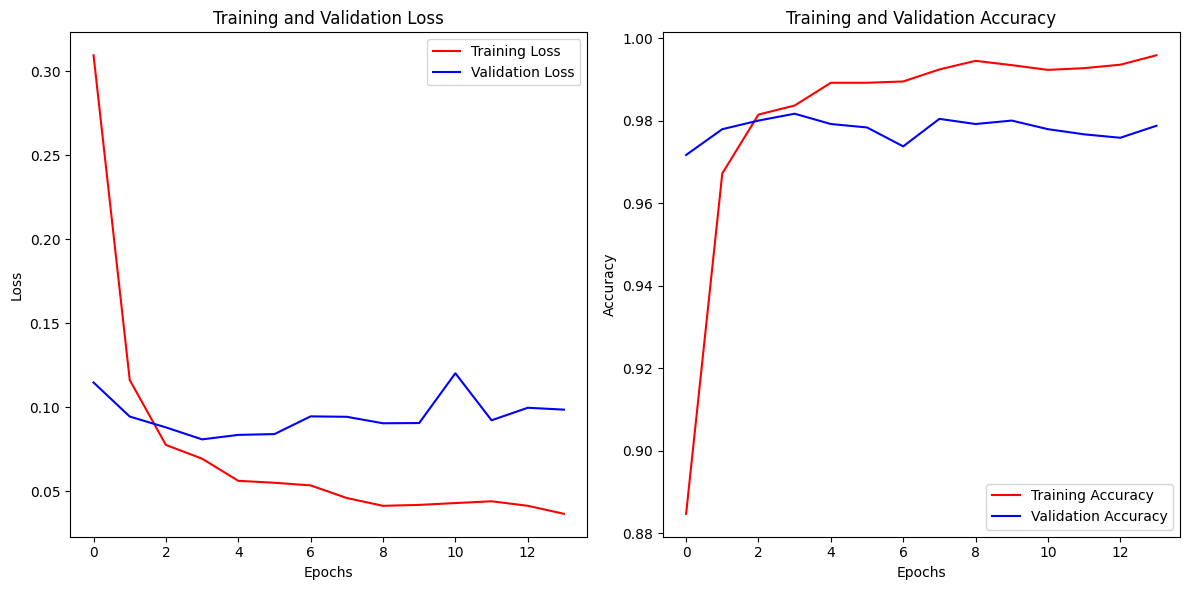

In [87]:
# plotting training curves for cnn model 



plot_loss_and_accuracy_curves(cnn_history)


In [101]:
test_text


array(['Once upon a time, Brian wrote :\n\n>     Yeah, I need to work this out, too; I just learned my lesson about\n>     living on the bleeding edge. Lesson learned?  NO MORE XIMIAN, UNDER\n>     ANY CIRCUMSTANCES.  Man, that was annoying.\n\nWe all learned that sooner or later, right? When I got down to that myself\nis when I started redhat.aldil.org, now known as freshrpms.net ;-)\n\n>     Anyway, I have returned to Redhat 7.3 on my root filesystem (saved my\n>     home directories, music and games on other partitions) and while I\n>     have the 8.0 stuff in the list, everything I want to upgrade requires\n>     200+ RPMs.\n> \n>     I\'m not opposed to this, but apt is.  "apt-get dist-upgrade" dumps\n>     core.\n\nStrange.\nAnyway, although I\'d easily recommend upgrading 7.x to 7.3 using apt, I\nwouldn\'t for 7.x to 8.0 as they are C++ binary incompatible... and apt is\nentirely written in C++ and dynamically linked :-/\n\nStill, that doesn\'t explain a core dump :-(\n\n>     W

### Evaluating CNN model

In [ ]:
# Preprocess the test text data using the text vectorizer
processed_test_text = text_vectorizer(test_text)

# Predict using the CNN model
pred_labels_cnn = cnn_model.predict(processed_test_text)

# Average over the time steps
avg_pred_labels_cnn = np.mean(pred_labels_cnn, axis=1)

# Flatten and round the predictions
avg_pred_labels_cnn = np.round(avg_pred_labels_cnn.flatten())

94/94 [==============================] - 1s 4ms/step


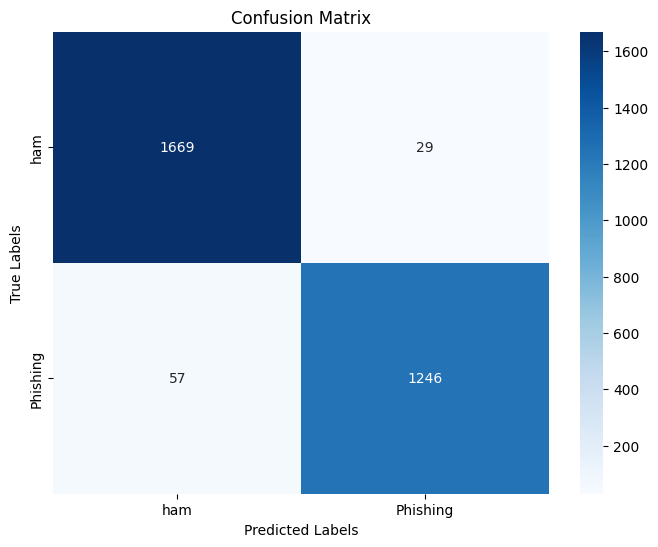

In [106]:
plot_confusion_matrix(y_pred=avg_pred_labels_cnn,y_true=test_labels)

In [107]:
# calcualting metrics for cnn model 
cnn_results=calculate_results(avg_pred_labels_cnn,test_labels)
print(f'metrics for cnn model are \n\n {cnn_results}')

metrics for cnn model are 

 {'accuracy': 0.9713428857047651, 'precision': 0.9715916881160044, 'recall': 0.9713428857047651, 'f1': 0.9713813372843731}


In [108]:
# classification report of  cnn_model  
report_2=classification_report(test_labels, avg_pred_labels_cnn)
print(f"classification report for cnn_model \n\n {report_2}")

classification report for cnn_model 

               precision    recall  f1-score   support

           0       0.97      0.98      0.97      1698
           1       0.98      0.96      0.97      1303

    accuracy                           0.97      3001
   macro avg       0.97      0.97      0.97      3001
weighted avg       0.97      0.97      0.97      3001



In [109]:
# calculating other metrices for cnn_model
print('other metrics for cnn_model\n')
for key , value in calculate_metrics(test_labels, avg_pred_labels_cnn).items():
    
    print(key,value,'\n')

other metrics for cnn_model

False Discovery Rate (FDR) 0.022745098039215685 

False Negative Rate (FNR) 0.043745203376822715 

False Omission Rate (FOR) 0.03302433371958285 

False Positive Rate (FPR) 0.01707891637220259 

Negative Prediction Value (NPV) 0.9669756662804172 



## GRU model 

In [113]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
gru_model_embedding = layers.Embedding(input_dim=20000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=1024,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = gru_model_embedding(x)
x = layers.GRU(64, return_sequences=False)(x) # stacking recurrent cells requires return_sequences=True   
# x = layers.GRU(64)(x) 

x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell

outputs = layers.Dense(1, activation="sigmoid")(x)
gru_model = tf.keras.Model(inputs, outputs, name="GRU_model")
gru_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
gru_model.summary()

Model: "GRU_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 1024)             0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, 1024, 128)         2560000   
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                         

In [114]:
# creaing early_stopping_callback for gru model with 5 epochs patinence  
gru_early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Verbosity mode (0, 1, or 2)
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [115]:
# fitting GRU model 
gru_model_history=gru_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[create_tensorboard_callback(file_path='logs/gru_model_tensorboard'),gru_early_stopping_callback,
                       create_checkpoint_callback(file_path='checkpoints/gru_model')])

Epoch 1/50
375/375 [==============================] - ETA: 0s - loss: 0.6839 - accuracy: 0.5697

INFO:tensorflow:Assets written to: checkpoints\gru_model\assets


INFO:tensorflow:Assets written to: checkpoints\gru_model\assets


375/375 [==============================] - 74s 181ms/step - loss: 0.6839 - accuracy: 0.5697 - val_loss: 0.6805 - val_accuracy: 0.5725
Epoch 2/50
375/375 [==============================] - ETA: 0s - loss: 0.6633 - accuracy: 0.5829

INFO:tensorflow:Assets written to: checkpoints\gru_model\assets


INFO:tensorflow:Assets written to: checkpoints\gru_model\assets


375/375 [==============================] - 71s 190ms/step - loss: 0.6633 - accuracy: 0.5829 - val_loss: 0.6712 - val_accuracy: 0.5748
Epoch 3/50
375/375 [==============================] - 68s 181ms/step - loss: 0.6532 - accuracy: 0.5873 - val_loss: 0.6716 - val_accuracy: 0.5768
Epoch 4/50
375/375 [==============================] - 77s 205ms/step - loss: 0.6550 - accuracy: 0.5866 - val_loss: 0.6725 - val_accuracy: 0.5768
Epoch 5/50
375/375 [==============================] - 77s 205ms/step - loss: 0.6566 - accuracy: 0.5882 - val_loss: 0.6745 - val_accuracy: 0.5735
Epoch 6/50
375/375 [==============================] - 73s 194ms/step - loss: 0.6520 - accuracy: 0.5878 - val_loss: 0.6730 - val_accuracy: 0.5771
Epoch 7/50
375/375 [==============================] - 73s 196ms/step - loss: 0.6508 - accuracy: 0.5879 - val_loss: 0.6782 - val_accuracy: 0.5755
Epoch 8/50
375/375 [==============================] - 79s 210ms/step - loss: 0.6507 - accuracy: 0.5882 - val_loss: 0.6742 - val_accuracy: 0.5

INFO:tensorflow:Assets written to: checkpoints\gru_model\assets


INFO:tensorflow:Assets written to: checkpoints\gru_model\assets


375/375 [==============================] - 91s 242ms/step - loss: 0.6193 - accuracy: 0.6246 - val_loss: 0.2737 - val_accuracy: 0.9177
Epoch 10/50
375/375 [==============================] - ETA: 0s - loss: 0.1356 - accuracy: 0.9614

INFO:tensorflow:Assets written to: checkpoints\gru_model\assets


INFO:tensorflow:Assets written to: checkpoints\gru_model\assets


375/375 [==============================] - 94s 252ms/step - loss: 0.1356 - accuracy: 0.9614 - val_loss: 0.1311 - val_accuracy: 0.9667
Epoch 11/50
375/375 [==============================] - ETA: 0s - loss: 0.0534 - accuracy: 0.9853

INFO:tensorflow:Assets written to: checkpoints\gru_model\assets


INFO:tensorflow:Assets written to: checkpoints\gru_model\assets


375/375 [==============================] - 97s 259ms/step - loss: 0.0534 - accuracy: 0.9853 - val_loss: 0.0812 - val_accuracy: 0.9737
Epoch 12/50
375/375 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 0.9934

INFO:tensorflow:Assets written to: checkpoints\gru_model\assets


INFO:tensorflow:Assets written to: checkpoints\gru_model\assets


375/375 [==============================] - 92s 244ms/step - loss: 0.0240 - accuracy: 0.9934 - val_loss: 0.0810 - val_accuracy: 0.9727
Epoch 13/50
375/375 [==============================] - 68s 182ms/step - loss: 0.0116 - accuracy: 0.9971 - val_loss: 0.1156 - val_accuracy: 0.9727
Epoch 14/50
375/375 [==============================] - 74s 198ms/step - loss: 0.0078 - accuracy: 0.9986 - val_loss: 0.0850 - val_accuracy: 0.9770
Epoch 15/50
375/375 [==============================] - 65s 173ms/step - loss: 0.0078 - accuracy: 0.9981 - val_loss: 0.0937 - val_accuracy: 0.9757
Epoch 16/50
375/375 [==============================] - 66s 177ms/step - loss: 0.0050 - accuracy: 0.9985 - val_loss: 0.0970 - val_accuracy: 0.9773
Epoch 17/50
375/375 [==============================] - 63s 167ms/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 0.1080 - val_accuracy: 0.9767
Epoch 18/50
375/375 [==============================] - 66s 175ms/step - loss: 0.0032 - accuracy: 0.9991 - val_loss: 0.1104 - val_accurac

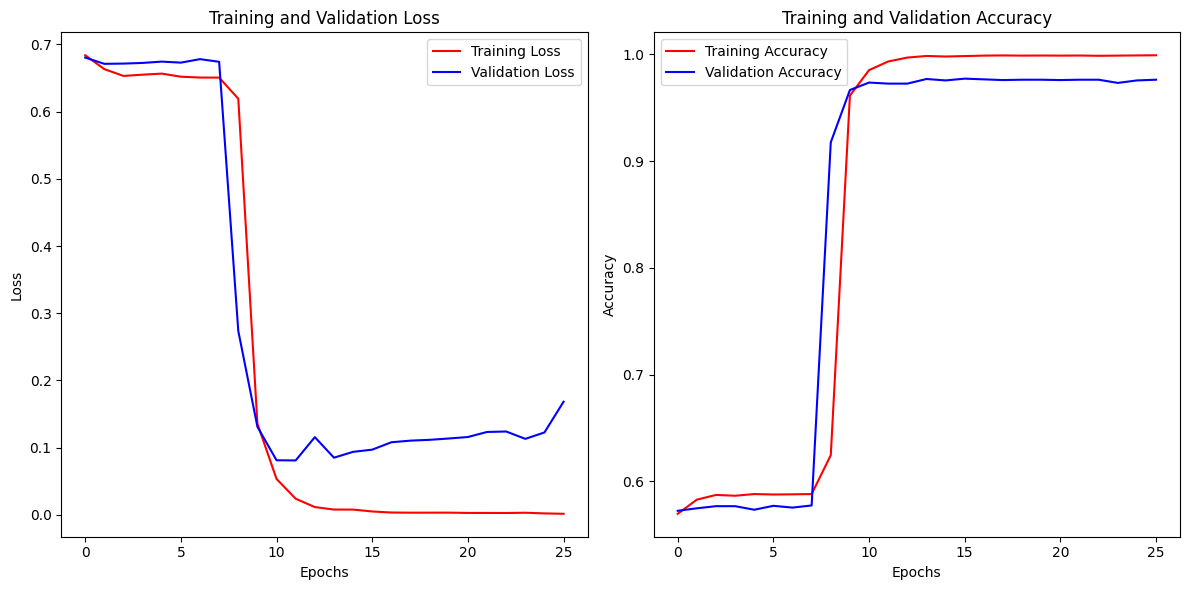

In [116]:
# plotting training curves for GRU model 


plot_loss_and_accuracy_curves(gru_model_history)


### Evaluating GRU model  

In [118]:

pred_labels_gru=gru_model.predict(test_text)

# Average over the time steps
avg_pred_labels_gru = np.mean(pred_labels_gru, axis=1)

# avg_pred_labels_lstm2.flatten().shape
avg_pred_labels_gru=np.round(avg_pred_labels_gru.flatten())

94/94 [==============================] - 10s 101ms/step


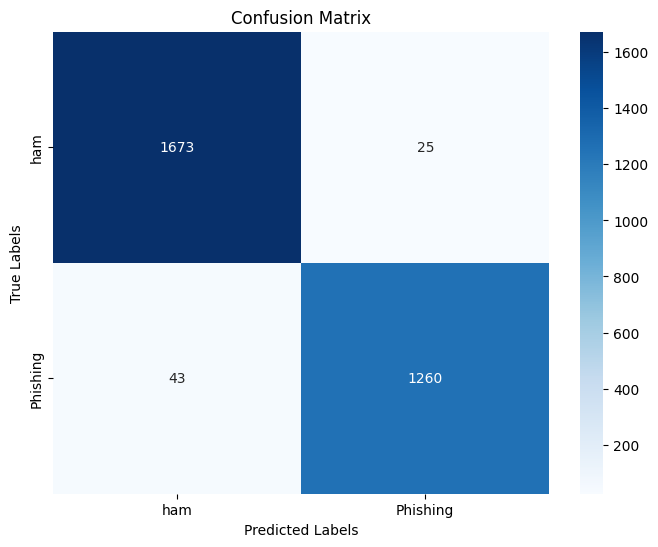

In [119]:
# plotting confusion matrix for gru_model 
plot_confusion_matrix(y_pred=avg_pred_labels_gru,y_true=test_labels)

In [120]:
# calculating metrices for gru_model
gru_results=calculate_results(avg_pred_labels_gru,test_labels)
print('metrics for gru_model\n')

for key ,value in gru_results.items() : 
    print(key,value,'\n')

metrics for gru_model

accuracy 0.9773408863712096 

precision 0.9774505152104067 

recall 0.9773408863712096 

f1 0.9773599514096499 



In [121]:
# classification report of gru_model 
report_3=classification_report(test_labels,avg_pred_labels_gru)
print(f"classification report for gru_model \n\n {report_3}")

classification report for gru_model 

               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1698
           1       0.98      0.97      0.97      1303

    accuracy                           0.98      3001
   macro avg       0.98      0.98      0.98      3001
weighted avg       0.98      0.98      0.98      3001



In [122]:
# calculating other metrices for gru_model
print('other metrics for gru_model\n')
for key , value in calculate_metrics(test_labels,avg_pred_labels_gru).items():
    
    print(key,value,'\n')

other metrics for gru_model

False Discovery Rate (FDR) 0.019455252918287938 

False Negative Rate (FNR) 0.03300076745970836 

False Omission Rate (FOR) 0.02505827505827506 

False Positive Rate (FPR) 0.014723203769140165 

Negative Prediction Value (NPV) 0.9749417249417249 



In [123]:
# function to predict class of input message 
def predict_message_class(model, message):
    # Ensure the input message is in the correct format
    message = tf.convert_to_tensor([message])
    
    # Predict using the model
    prediction = model.predict(message)
    
    return prediction

# Example usage:
phishing_message = """Our records indicate that your payment method for your streaming service subscription has expired. To avoid interruption of your service, please update your payment information immediately. Click here to update your payment details: [deceptive link] Your account overview: Username: [email address] Subscription: Premium Plan Next billing date: [tomorrow's date] If you do not update your payment method within 24 hours, your account will be downgraded to the free plan with limited access.
"""
prediction = predict_message_class(gru_model, phishing_message)
avg_prediction=np.mean(prediction, axis=1)
avg_prediction=np.round(avg_prediction.flatten())
print('predicted: phishing message' if avg_prediction[0]==1 else 'predicted: benign message')

1/1 [==============================] - 0s 121ms/step
predicted: phishing message


## Bidirectonal LSTM model 

In [124]:
# creating embedding layer for bidirectional lstm model 
bidirectonal_embedding = layers.Embedding(input_dim=20000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=1024,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = bidirectonal_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
bidirectonal_model = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")
bidirectonal_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [125]:
bidirectonal_model.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 1024)             0         
 torization)                                                     
                                                                 
 embedding_4 (Embedding)     (None, 1024, 128)         2560000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,658,945
Trainable params: 2,6

In [127]:
# training bidirectonal_model
bidirectonal_model_history=bidirectonal_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[create_tensorboard_callback(file_path='logs/bidirectonal_model_tensorboard'),early_stopping_callback,
                       create_checkpoint_callback(file_path='checkpoints/bidirectonal_model')])

Epoch 1/50
375/375 [==============================] - ETA: 0s - loss: 0.1815 - accuracy: 0.9322

INFO:tensorflow:Assets written to: checkpoints\bidirectonal_model\assets


INFO:tensorflow:Assets written to: checkpoints\bidirectonal_model\assets


375/375 [==============================] - 159s 407ms/step - loss: 0.1815 - accuracy: 0.9322 - val_loss: 0.1029 - val_accuracy: 0.9623
Epoch 2/50
375/375 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 0.9883

INFO:tensorflow:Assets written to: checkpoints\bidirectonal_model\assets


INFO:tensorflow:Assets written to: checkpoints\bidirectonal_model\assets


375/375 [==============================] - 136s 362ms/step - loss: 0.0376 - accuracy: 0.9883 - val_loss: 0.0722 - val_accuracy: 0.9770
Epoch 3/50
375/375 [==============================] - 115s 305ms/step - loss: 0.0157 - accuracy: 0.9950 - val_loss: 0.0933 - val_accuracy: 0.9663
Epoch 4/50
375/375 [==============================] - 110s 294ms/step - loss: 0.0141 - accuracy: 0.9958 - val_loss: 0.0908 - val_accuracy: 0.9680
Epoch 5/50
375/375 [==============================] - 111s 295ms/step - loss: 0.0086 - accuracy: 0.9965 - val_loss: 0.0881 - val_accuracy: 0.9720
Epoch 6/50
375/375 [==============================] - 131s 349ms/step - loss: 0.0033 - accuracy: 0.9987 - val_loss: 0.1027 - val_accuracy: 0.9720
Epoch 7/50
375/375 [==============================] - 120s 320ms/step - loss: 0.0026 - accuracy: 0.9989 - val_loss: 0.1573 - val_accuracy: 0.9623
Epoch 8/50
375/375 [==============================] - 121s 323ms/step - loss: 0.0029 - accuracy: 0.9984 - val_loss: 0.1179 - val_accura

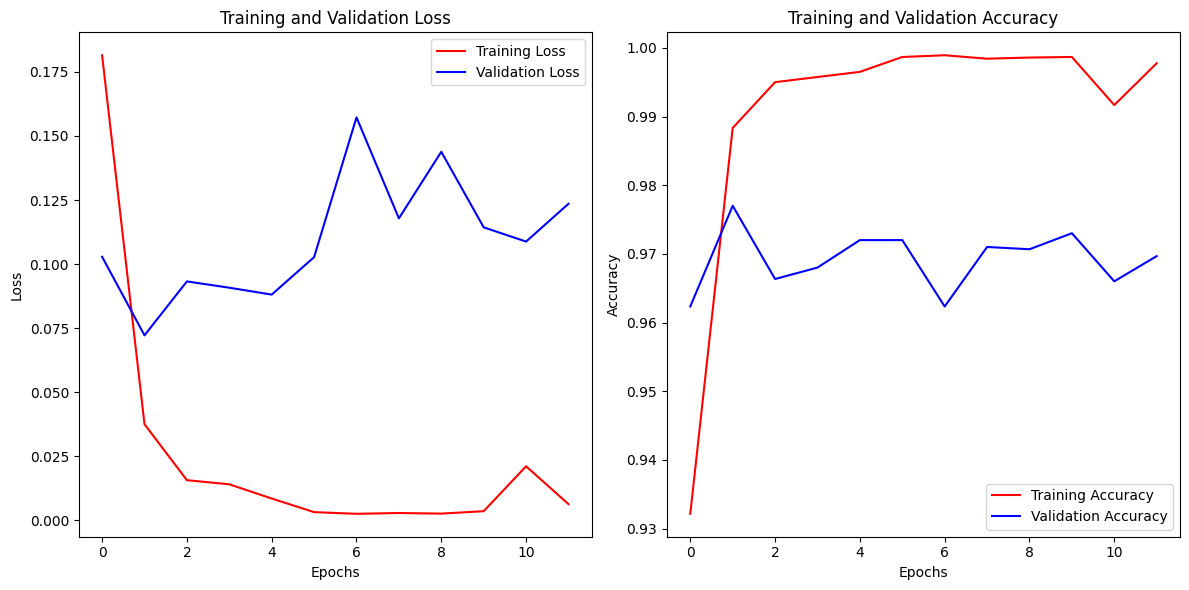

In [128]:
# plotting training curves for Bidirectional LSTM model 


plot_loss_and_accuracy_curves(bidirectonal_model_history)

### Evaluating Bidirectonal LSTM model

In [130]:
# predicting results for bidirectonal_model 
pred_labels_bidirectonal_model=bidirectonal_model.predict(test_text)


94/94 [==============================] - 17s 149ms/step


In [131]:
# Average over the time steps
avg_pred_labels_bidirectonal_model = np.mean(pred_labels_bidirectonal_model, axis=1)

avg_pred_labels_bidirectonal_model=np.round(avg_pred_labels_bidirectonal_model.flatten())
bidirectonal_model_results=calculate_results(avg_pred_labels_bidirectonal_model,test_labels)
print('Metrics for bidirectonal_model\n')
for key ,value in bidirectonal_model_results.items() : 
    print(key,value,'\n')

Metrics for bidirectonal_model

accuracy 0.9770076641119627 

precision 0.9773929833465016 

recall 0.9770076641119627 

f1 0.9770493347987735 



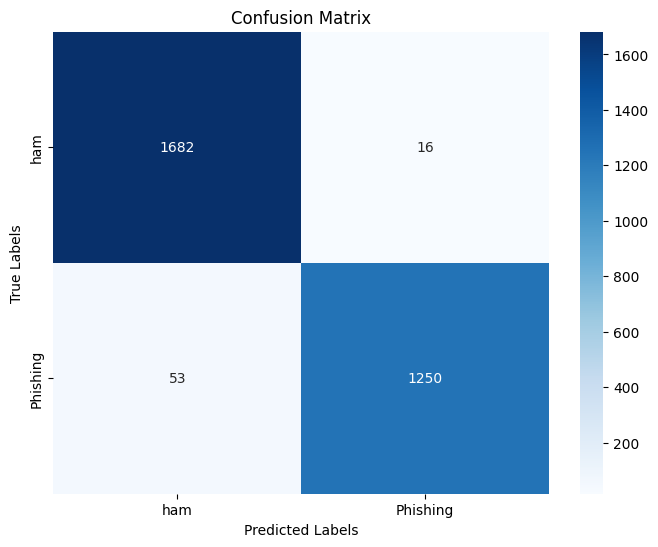

In [133]:
# plotting confusion matrix for bidirectonal_model 
plot_confusion_matrix(y_pred=avg_pred_labels_bidirectonal_model,y_true=test_labels)

In [135]:
# classification report of bidirectonal_model 
report_4=classification_report(test_labels,avg_pred_labels_bidirectonal_model)
print(f"classification report for bidirectonal_model \n\n {report_4}")

classification report for bidirectonal_model 

               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1698
           1       0.99      0.96      0.97      1303

    accuracy                           0.98      3001
   macro avg       0.98      0.97      0.98      3001
weighted avg       0.98      0.98      0.98      3001



In [136]:
# calculating other metrices for bidirectonal_model
print('Other metrics for bidirectonal_model\n')
for key , value in calculate_metrics(test_labels,avg_pred_labels_bidirectonal_model).items():
    
    print(key,value,'\n')

Other metrics for bidirectonal_model

False Discovery Rate (FDR) 0.01263823064770932 

False Negative Rate (FNR) 0.04067536454336147 

False Omission Rate (FOR) 0.03054755043227666 

False Positive Rate (FPR) 0.009422850412249705 

Negative Prediction Value (NPV) 0.9694524495677234 



## A simple dense model

In [137]:
# Build model with the Functional API
dense_embedding = layers.Embedding(input_dim=20000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=1024,
                                     name="embedding_5")

inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = dense_embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
dense_model = tf.keras.Model(inputs, outputs, name="dense_model") # construct the model
dense_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
dense_model.summary()

Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 1024)             0         
 torization)                                                     
                                                                 
 embedding_5 (Embedding)     (None, 1024, 128)         2560000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,560,129
Trainable params: 2,560,129
Non

In [138]:
# creating custom early stopping callback for dense model with higher patience 
dense_early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',    # Monitor the validation loss
    patience=15,           # Number of epochs with no improvement after which training will be stopped
    verbose=1,             # Verbosity mode
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored quantity
mode='max')

In [139]:
# trainging dense model 
dense_model_history=dense_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[create_tensorboard_callback(file_path='logs/dense_model_tensorboard'),dense_early_stopping_callback,
                       create_checkpoint_callback(file_path='checkpoints/dense_model')])

Epoch 1/50
374/375 [============================>.] - ETA: 0s - loss: 0.5400 - accuracy: 0.7331INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


375/375 [==============================] - 17s 37ms/step - loss: 0.5396 - accuracy: 0.7336 - val_loss: 0.4013 - val_accuracy: 0.8491
Epoch 2/50
375/375 [==============================] - ETA: 0s - loss: 0.2928 - accuracy: 0.8949INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


375/375 [==============================] - 10s 27ms/step - loss: 0.2928 - accuracy: 0.8949 - val_loss: 0.2536 - val_accuracy: 0.8987
Epoch 3/50
374/375 [============================>.] - ETA: 0s - loss: 0.1956 - accuracy: 0.9326INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


375/375 [==============================] - 11s 28ms/step - loss: 0.1955 - accuracy: 0.9327 - val_loss: 0.2028 - val_accuracy: 0.9174
Epoch 4/50
374/375 [============================>.] - ETA: 0s - loss: 0.1513 - accuracy: 0.9489INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


375/375 [==============================] - 10s 28ms/step - loss: 0.1512 - accuracy: 0.9489 - val_loss: 0.1769 - val_accuracy: 0.9267
Epoch 5/50
375/375 [==============================] - ETA: 0s - loss: 0.1234 - accuracy: 0.9591INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


375/375 [==============================] - 10s 25ms/step - loss: 0.1234 - accuracy: 0.9591 - val_loss: 0.1544 - val_accuracy: 0.9427
Epoch 6/50
375/375 [==============================] - ETA: 0s - loss: 0.1041 - accuracy: 0.9657INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


375/375 [==============================] - 11s 29ms/step - loss: 0.1041 - accuracy: 0.9657 - val_loss: 0.1494 - val_accuracy: 0.9377
Epoch 7/50
373/375 [============================>.] - ETA: 0s - loss: 0.0899 - accuracy: 0.9716INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


375/375 [==============================] - 13s 34ms/step - loss: 0.0898 - accuracy: 0.9715 - val_loss: 0.1434 - val_accuracy: 0.9400
Epoch 8/50
375/375 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.9747INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


375/375 [==============================] - 11s 29ms/step - loss: 0.0783 - accuracy: 0.9747 - val_loss: 0.1285 - val_accuracy: 0.9503
Epoch 9/50
373/375 [============================>.] - ETA: 0s - loss: 0.0691 - accuracy: 0.9775INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


375/375 [==============================] - 10s 27ms/step - loss: 0.0690 - accuracy: 0.9777 - val_loss: 0.1138 - val_accuracy: 0.9587
Epoch 10/50
374/375 [============================>.] - ETA: 0s - loss: 0.0609 - accuracy: 0.9812INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


375/375 [==============================] - 12s 33ms/step - loss: 0.0610 - accuracy: 0.9812 - val_loss: 0.1130 - val_accuracy: 0.9583
Epoch 11/50
373/375 [============================>.] - ETA: 0s - loss: 0.0539 - accuracy: 0.9827INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


375/375 [==============================] - 10s 27ms/step - loss: 0.0537 - accuracy: 0.9828 - val_loss: 0.1076 - val_accuracy: 0.9610
Epoch 12/50
375/375 [==============================] - 8s 22ms/step - loss: 0.0485 - accuracy: 0.9847 - val_loss: 0.1111 - val_accuracy: 0.9593
Epoch 13/50
372/375 [============================>.] - ETA: 0s - loss: 0.0435 - accuracy: 0.9858INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


375/375 [==============================] - 9s 25ms/step - loss: 0.0434 - accuracy: 0.9858 - val_loss: 0.1002 - val_accuracy: 0.9633
Epoch 14/50
375/375 [==============================] - 8s 22ms/step - loss: 0.0395 - accuracy: 0.9876 - val_loss: 0.1007 - val_accuracy: 0.9630
Epoch 15/50
375/375 [==============================] - 8s 21ms/step - loss: 0.0355 - accuracy: 0.9882 - val_loss: 0.1150 - val_accuracy: 0.9587
Epoch 16/50
374/375 [============================>.] - ETA: 0s - loss: 0.0335 - accuracy: 0.9896INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


375/375 [==============================] - 9s 25ms/step - loss: 0.0335 - accuracy: 0.9897 - val_loss: 0.0985 - val_accuracy: 0.9640
Epoch 17/50
373/375 [============================>.] - ETA: 0s - loss: 0.0304 - accuracy: 0.9904INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


375/375 [==============================] - 13s 35ms/step - loss: 0.0304 - accuracy: 0.9905 - val_loss: 0.0962 - val_accuracy: 0.9650
Epoch 18/50
373/375 [============================>.] - ETA: 0s - loss: 0.0284 - accuracy: 0.9910INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


INFO:tensorflow:Assets written to: checkpoints\dense_model\assets


375/375 [==============================] - 11s 28ms/step - loss: 0.0283 - accuracy: 0.9910 - val_loss: 0.0930 - val_accuracy: 0.9663
Epoch 19/50
375/375 [==============================] - 8s 22ms/step - loss: 0.0256 - accuracy: 0.9922 - val_loss: 0.0972 - val_accuracy: 0.9653
Epoch 20/50
375/375 [==============================] - 8s 21ms/step - loss: 0.0236 - accuracy: 0.9921 - val_loss: 0.0999 - val_accuracy: 0.9643
Epoch 21/50
375/375 [==============================] - 8s 21ms/step - loss: 0.0223 - accuracy: 0.9927 - val_loss: 0.0957 - val_accuracy: 0.9677
Epoch 22/50
375/375 [==============================] - 9s 23ms/step - loss: 0.0206 - accuracy: 0.9930 - val_loss: 0.0982 - val_accuracy: 0.9663
Epoch 23/50
375/375 [==============================] - 8s 22ms/step - loss: 0.0193 - accuracy: 0.9937 - val_loss: 0.0939 - val_accuracy: 0.9773
Epoch 24/50
375/375 [==============================] - 8s 22ms/step - loss: 0.0179 - accuracy: 0.9939 - val_loss: 0.1109 - val_accuracy: 0.9640
Epo

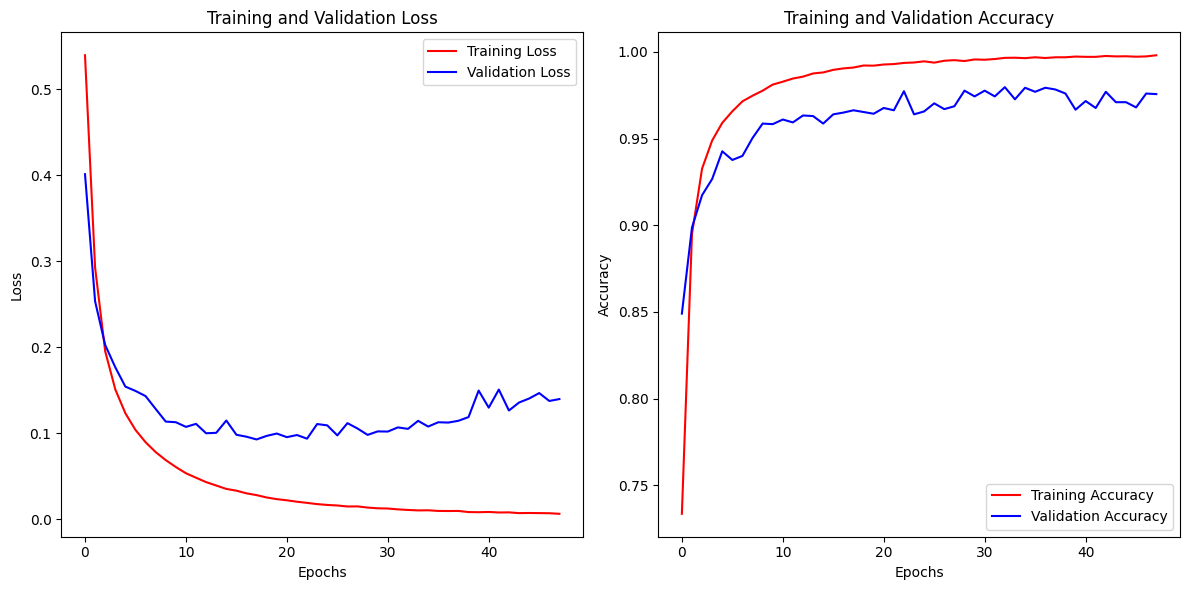

In [140]:
# plotting training curves for Dense model 


plot_loss_and_accuracy_curves(dense_model_history)

### Evaluating Dense model

In [142]:
# predicting results for dense_model 
pred_labels_dense_model=dense_model.predict(test_text)


94/94 [==============================] - 2s 15ms/step


In [143]:
# Average over the time steps
avg_pred_labels_dense_model = np.mean(pred_labels_dense_model, axis=1)

avg_pred_labels_dense_model=np.round(avg_pred_labels_dense_model.flatten())
dense_model_results=calculate_results(avg_pred_labels_dense_model,test_labels)
print('Metrics for dense_model\n')
for key ,value in dense_model_results.items() : 
    print(key,value,'\n')

Metrics for dense_model

accuracy 0.979673442185938 

precision 0.979720746019011 

recall 0.979673442185938 

f1 0.9796837098833736 



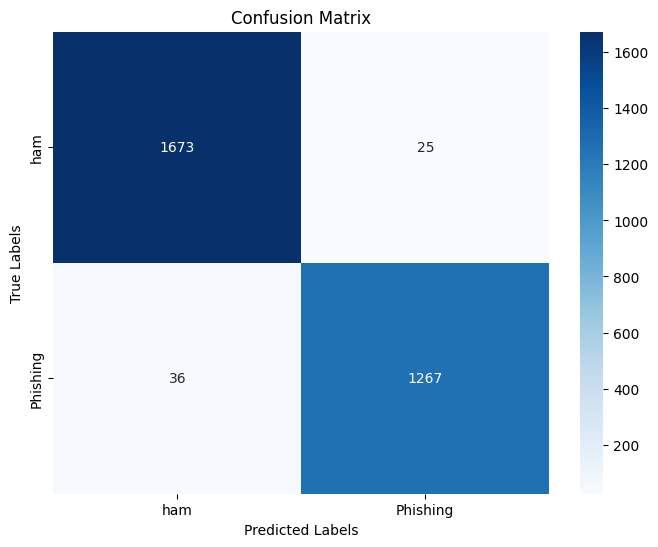

In [144]:
# plotting confusion matrix for dense_model 
plot_confusion_matrix(y_pred=avg_pred_labels_dense_model,y_true=test_labels)

In [145]:
# classification report of dense_model 
report_5=classification_report(test_labels,avg_pred_labels_dense_model)
print(f"classification report for dense_model \n\n {report_4}")

classification report for dense_model 

               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1698
           1       0.99      0.96      0.97      1303

    accuracy                           0.98      3001
   macro avg       0.98      0.97      0.98      3001
weighted avg       0.98      0.98      0.98      3001



In [146]:
# calculating other metrices for dense_model
print('Other metrics for dense_model\n')
for key , value in calculate_metrics(test_labels,avg_pred_labels_dense_model).items():
    
    print(key,value,'\n')

Other metrics for dense_model

False Discovery Rate (FDR) 0.01934984520123839 

False Negative Rate (FNR) 0.02762854950115119 

False Omission Rate (FOR) 0.021064950263311878 

False Positive Rate (FPR) 0.014723203769140165 

Negative Prediction Value (NPV) 0.9789350497366881 



### saving CNN model (best performance) , loading saved model ,evaluating loaded model and test it on single messages   

In [147]:
cnn_model.save('cnn_model', save_format='tf') # another fix 

INFO:tensorflow:Assets written to: cnn_model\assets


INFO:tensorflow:Assets written to: cnn_model\assets


In [149]:
loaded_cnn_model=tf.keras.models.load_model('cnn_model')
loaded_cnn_model

### loading saved model 


In [150]:
processed_test_text=text_vectorizer(test_text)
loaded_model_results=loaded_cnn_model.evaluate(processed_test_text,test_labels)
loaded_cnn_loss,loaded_cnn_accuracy=loaded_model_results
print(f'loaded cnn loss: {loaded_cnn_loss}','\n',f'loaded cnn accuracy: {loaded_cnn_accuracy}')

94/94 [==============================] - 1s 9ms/step - loss: 0.0972 - accuracy: 0.9713
loaded cnn loss: 0.09722396731376648 
 loaded cnn accuracy: 0.9713428616523743


## Evaluating loaded cnn model 

In [151]:
# predicting results for dense_model 
pred_labels_loaded_cnn_model=loaded_cnn_model.predict(processed_test_text)
# Average over the time steps
avg_pred_labels_loaded_cnn_model = np.mean(pred_labels_loaded_cnn_model, axis=1)

avg_pred_labels_loaded_cnn_model=np.round(avg_pred_labels_loaded_cnn_model.flatten())
loaded_cnn_model_results=calculate_results(avg_pred_labels_loaded_cnn_model,test_labels)
print('Metrics for loaded cnn model\n')
for key ,value in loaded_cnn_model_results.items() : 
    print(key,value,'\n')

94/94 [==============================] - 1s 4ms/step
Metrics for loaded cnn model

accuracy 0.9713428857047651 

precision 0.9715916881160044 

recall 0.9713428857047651 

f1 0.9713813372843731 



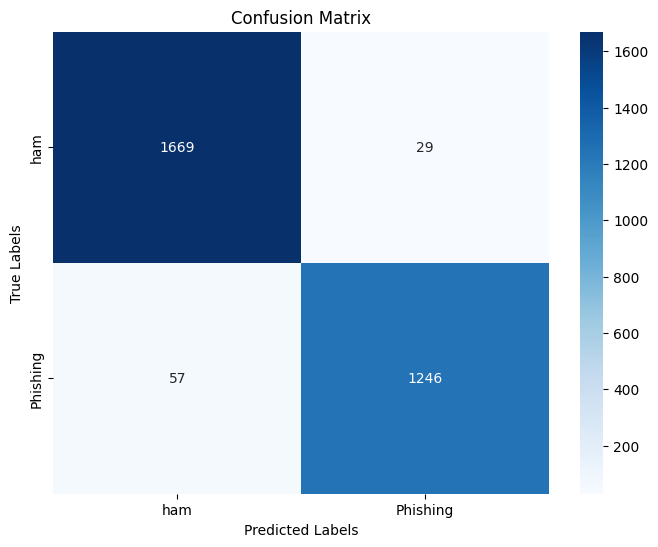

In [153]:
plot_confusion_matrix(y_pred=avg_pred_labels_loaded_cnn_model,y_true=test_labels)

In [154]:
phishing_message="""Dear user,

We have detected unusual activity in your account. To ensure the security of your personal information, we need you to verify your account details immediately. Please click the link below and provide your login credentials and other sensitive information:

Click here to verify your account(http://phishing-link.com)

Failure to verify your account within 24 hours will result in a temporary suspension of your account.

Thank you for your prompt attention to this matter.

Sincerely,
alex banx Security Team
"""
benign_message="Hello Ali , I'd like to invite you to my birthday party. all our friendes are coming."
pred=loaded_cnn_model.predict(text_vectorizer([benign_message]))
pred_class='phising message' if np.round(pred[0][0]) else 'Benign Message'
print(pred_class)
print('probability of phishing: ',pred[0][0])


1/1 [==============================] - 0s 220ms/step
Benign Message
probability of phishing:  0.18190327


### Creating tensorboard for experiments 
>##### to visualize tensorboard download logs.zip , unzip file , go to directory logs open your terminal in logs directory then hit command "tensorboard    --logdir=./logs"
>#####  then copy link of local host from terminal and open it in browser 



In [155]:
## zipping logs directory to download it and visualize tensorboards on local pc 
!zip -r /kaggle/working/logs.zip /kaggle/working/logs

'zip' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# zipping checkpoints directory to be able to download it 
!zip -r /kaggle/working/checkpoints.zip /kaggle/working/checkpoints

## Comparing models results 

In [156]:
# making a dictionary for models metrices 
result_dict={'cnn':cnn_results,'bidirectional':bidirectonal_model_results,'LSTM':lstm_model_1_results,
             'GRU':gru_results,'Dense':dense_model_results}
# making a dataframe of models results 
models_results_df=pd.DataFrame(result_dict)
models_results_df=models_results_df.transpose()
# multiplying results to 100 
for column in models_results_df.columns : 
    column_value=models_results_df[column].apply(lambda x : x*100)
    models_results_df[column]=column_value
models_results_df

,accuracy,precision,recall,f1
cnn,97.134289,97.159169,97.134289,97.138134
bidirectional,97.700766,97.739298,97.700766,97.704933
LSTM,81.239587,81.420523,81.239587,81.287004
GRU,97.734089,97.745052,97.734089,97.735995
Dense,97.967344,97.972075,97.967344,97.968371


In [158]:
# making a dictionary of other metrics for each model 
cnn_other_metrics=calculate_metrics(test_labels,avg_pred_labels_cnn)
bidirecctional_other_metrics=calculate_metrics(test_labels,avg_pred_labels_bidirectonal_model)
lstm_other_metrics=calculate_metrics(test_labels,avg_pred_labels_lstm1)
gru_other_metrics=calculate_metrics(test_labels,avg_pred_labels_gru)
dense_other_metrics=calculate_metrics(test_labels,avg_pred_labels_dense_model)

other_metrics={'cnn':cnn_other_metrics,
               'bidirectional':bidirecctional_other_metrics,'LSTM':lstm_other_metrics,
             'GRU':gru_other_metrics,'Dense':dense_other_metrics}
other_mertics_df=pd.DataFrame(other_metrics)
other_mertics_df=other_mertics_df.transpose()
for column in other_mertics_df.columns :
    other_mertics_df[column]=other_mertics_df[column].apply(lambda x :x *100)
other_mertics_df

,False Discovery Rate (FDR),False Negative Rate (FNR),False Omission Rate (FOR),False Positive Rate (FPR),Negative Prediction Value (NPV)
cnn,2.274510,4.374520,3.302433,1.707892,96.697567
bidirectional,1.263823,4.067536,3.054755,0.942285,96.945245
LSTM,23.032070,18.956255,15.162676,18.610130,84.837324
GRU,1.945525,3.300077,2.505828,1.472320,97.494172
Dense,1.934985,2.762855,2.106495,1.472320,97.893505


In [159]:
# concatinating all metrics in one dataframe 
all_metrics_df=pd.concat([models_results_df,other_mertics_df],axis=1)
all_metrics_df

,accuracy,precision,recall,f1,False Discovery Rate (FDR),False Negative Rate (FNR),False Omission Rate (FOR),False Positive Rate (FPR),Negative Prediction Value (NPV)
cnn,97.134289,97.159169,97.134289,97.138134,2.274510,4.374520,3.302433,1.707892,96.697567
bidirectional,97.700766,97.739298,97.700766,97.704933,1.263823,4.067536,3.054755,0.942285,96.945245
LSTM,81.239587,81.420523,81.239587,81.287004,23.032070,18.956255,15.162676,18.610130,84.837324
GRU,97.734089,97.745052,97.734089,97.735995,1.945525,3.300077,2.505828,1.472320,97.494172
Dense,97.967344,97.972075,97.967344,97.968371,1.934985,2.762855,2.106495,1.472320,97.893505


In [160]:
# making a function that plots a bar plot for comparion of metrics between columns 
def plot_bar_plot_of_metric(column_name : str , color : str):
    """
    Plots a bar chart of a specified metric from a DataFrame, sorted in descending order.

    Parameters:
    - column_name (str): The name of the column/metric to plot.
    - color (str): The color code for the bars in the plot (e.g., 'FF5733' for orange).

    Returns:
    - None: Displays the plot directly using matplotlib.

    Example Usage:
    >>> plot_bar_plot_of_metric('False Positive Rate (FPR)', 'FF5733')
    """

    

    ax = all_metrics_df.sort_values(column_name, ascending=False)[column_name].plot(kind='bar', figsize=(9, 8), color=f'#{color}')

    # Adding value labels above each bar
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5),
                    textcoords='offset points')

    # Adding title and labels
    plt.title(f'Models Sorted Descendingly by {column_name}')
    plt.ylabel(f'{column_name}%', fontsize=12)

    # Adding grid and rotating x-axis labels
    plt.grid()
    plt.xticks(rotation=0)

    # Displaying the plot
    plt.show()

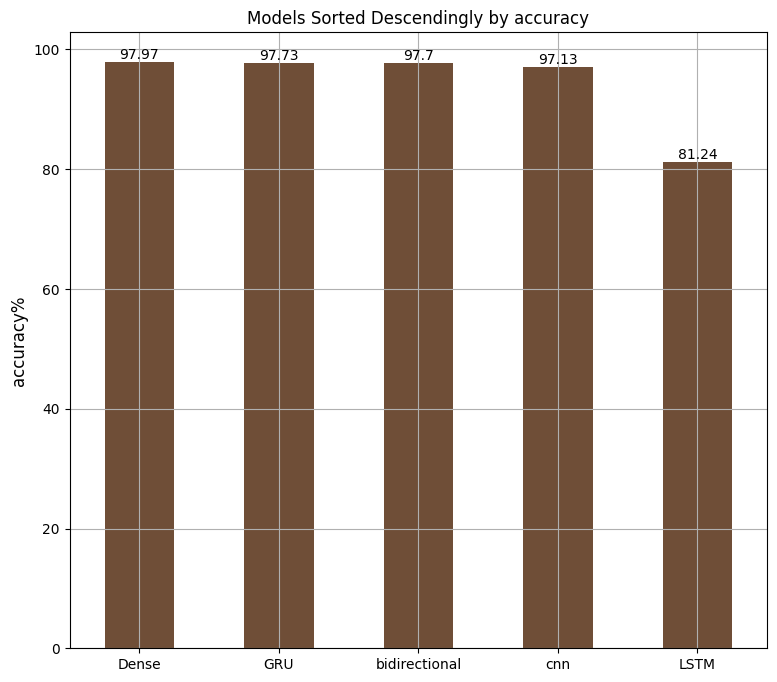

In [161]:
# plotting bar plot for models sorted descendingly by accuracy

plot_bar_plot_of_metric('accuracy','6F4E37')

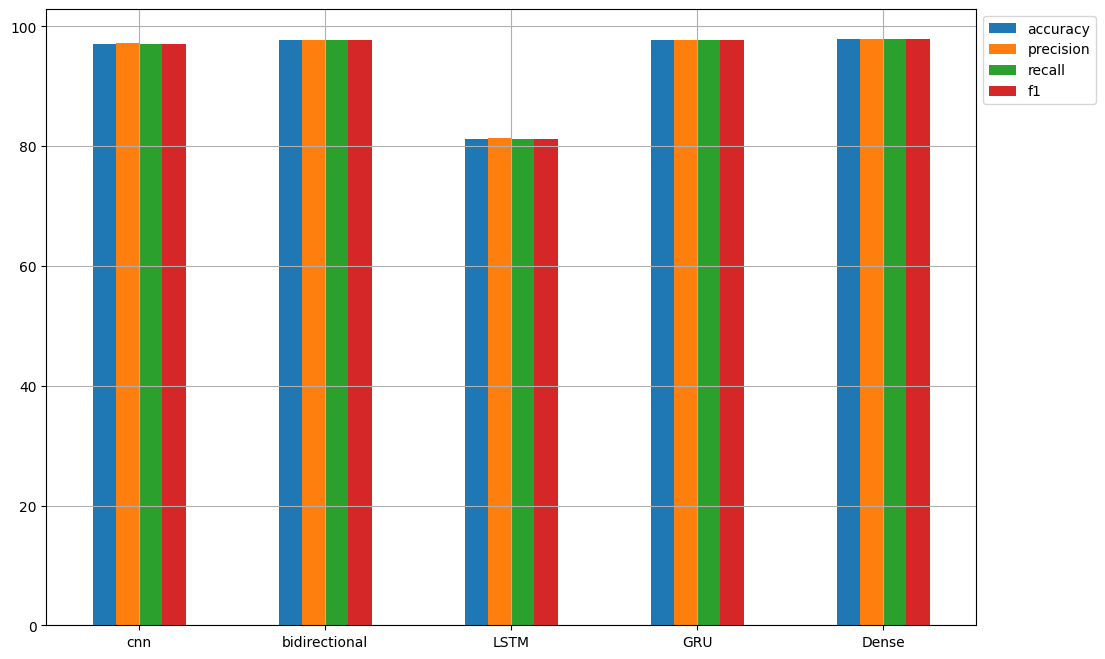

In [162]:
models_results_df.plot(kind='bar',figsize=(12,8)).legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=0)
plt.grid()

plt.show()

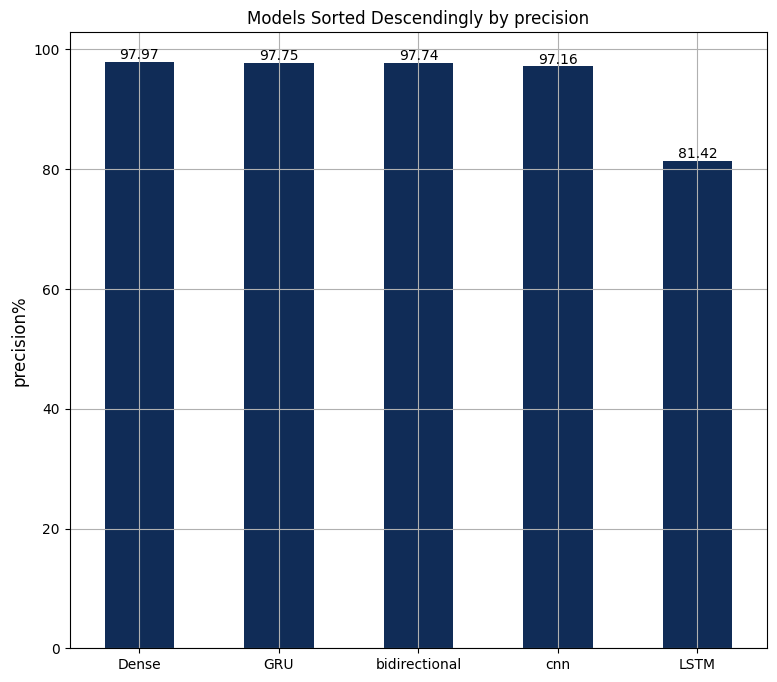

In [163]:
# plotting bar plot for models sorted descendingly by precision
plot_bar_plot_of_metric('precision','102C57')

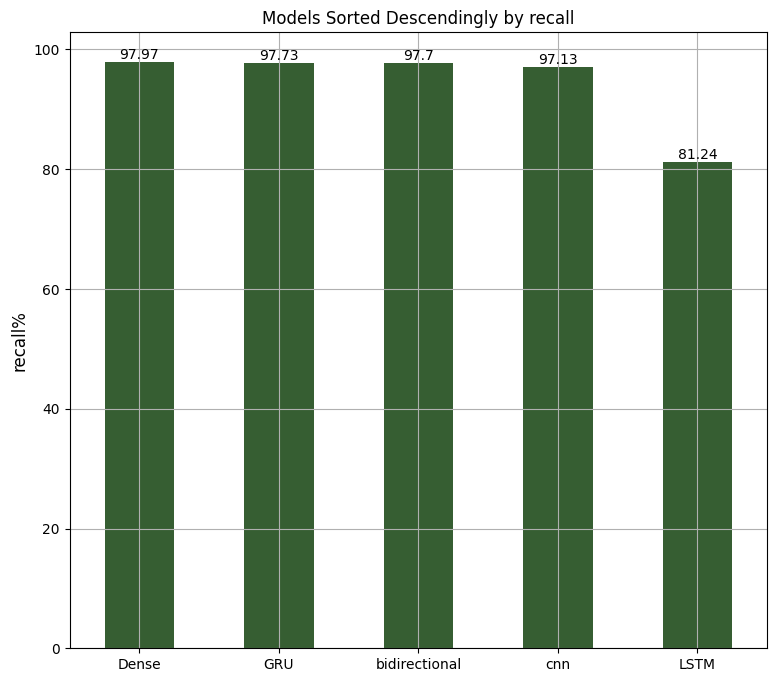

In [164]:
# plotting bar plot for models sorted descendingly by recall 
plot_bar_plot_of_metric('recall','365E32')

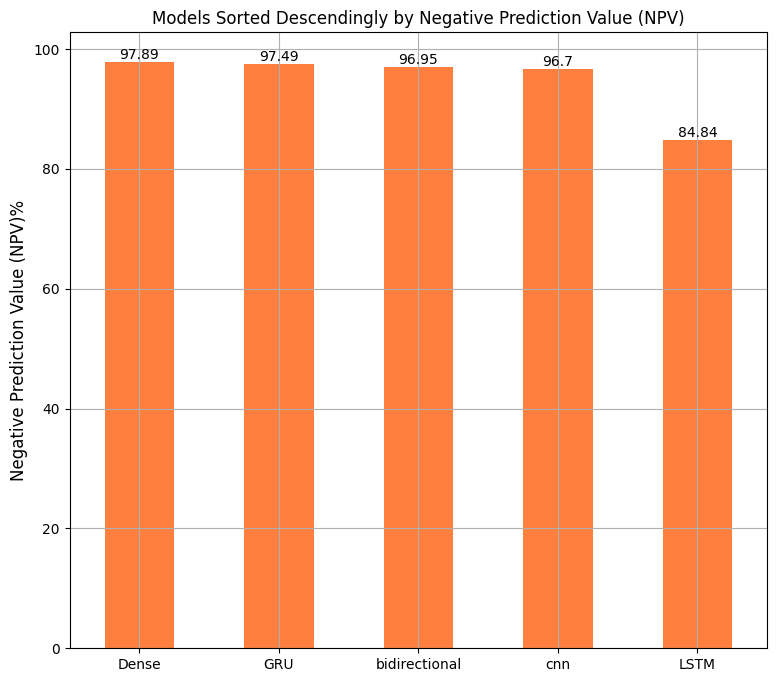

In [165]:
# Plotting bar plot for models sorted descendingly by NPV
plot_bar_plot_of_metric('Negative Prediction Value (NPV)','FF7F3E')

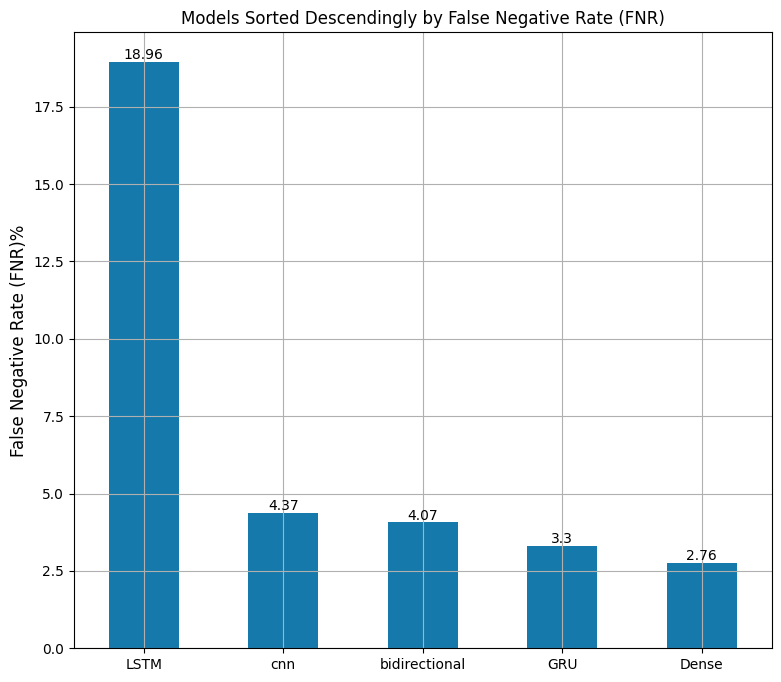

In [166]:
# Plotting bar plot for models sorted descendingly by FNR

plot_bar_plot_of_metric('False Negative Rate (FNR)','1679AB')

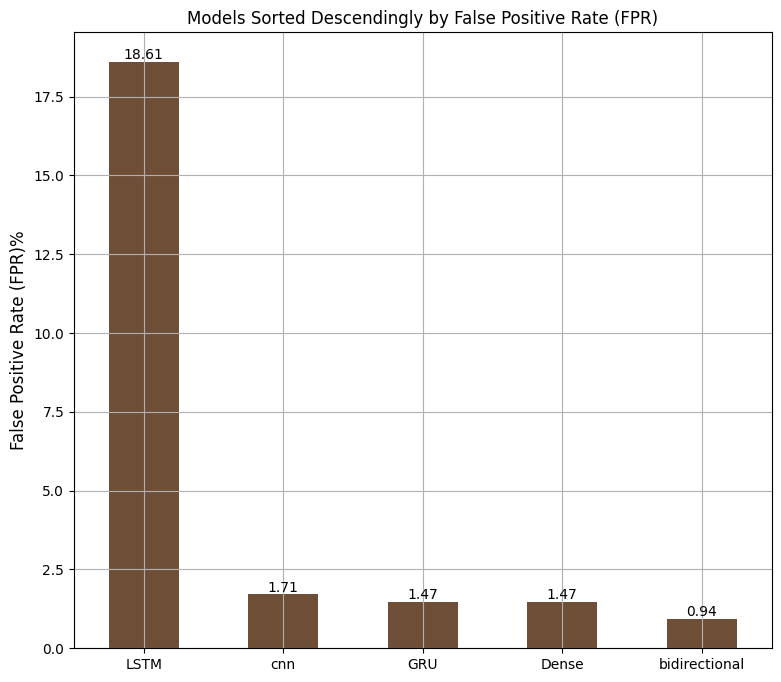

In [167]:
# Plotting bar plot for models sorted descendingly by FPR

plot_bar_plot_of_metric('False Positive Rate (FPR)','6F4E37')

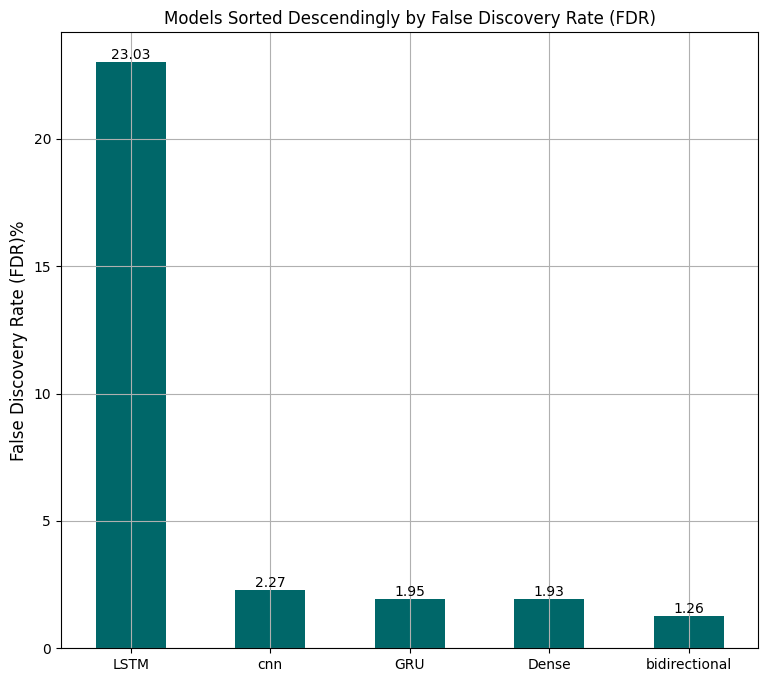

In [168]:
# Plotting bar plot for models sorted descendingly by FDR

plot_bar_plot_of_metric('False Discovery Rate (FDR)','006769')

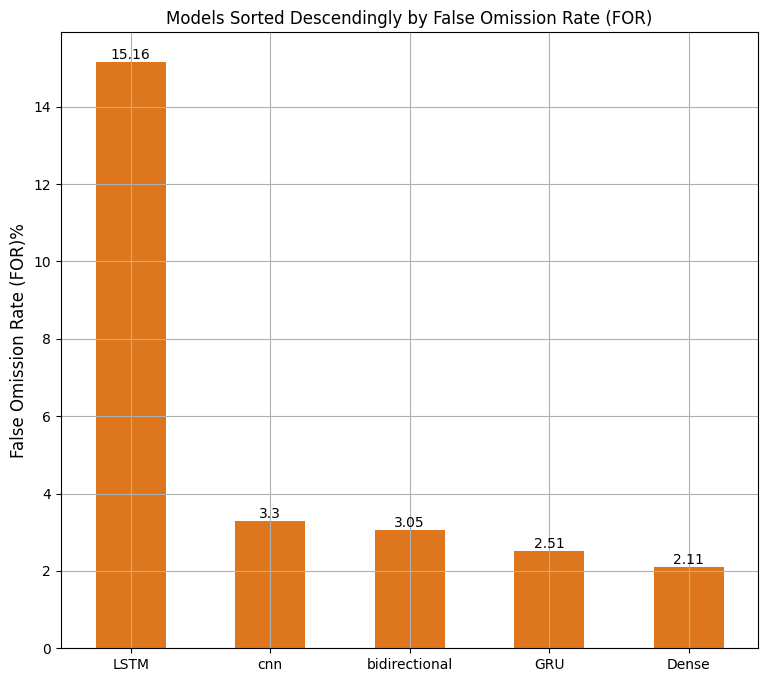

In [169]:
# Plotting bar plot for models sorted descendingly by FOR

plot_bar_plot_of_metric('False Omission Rate (FOR)','DD761C')

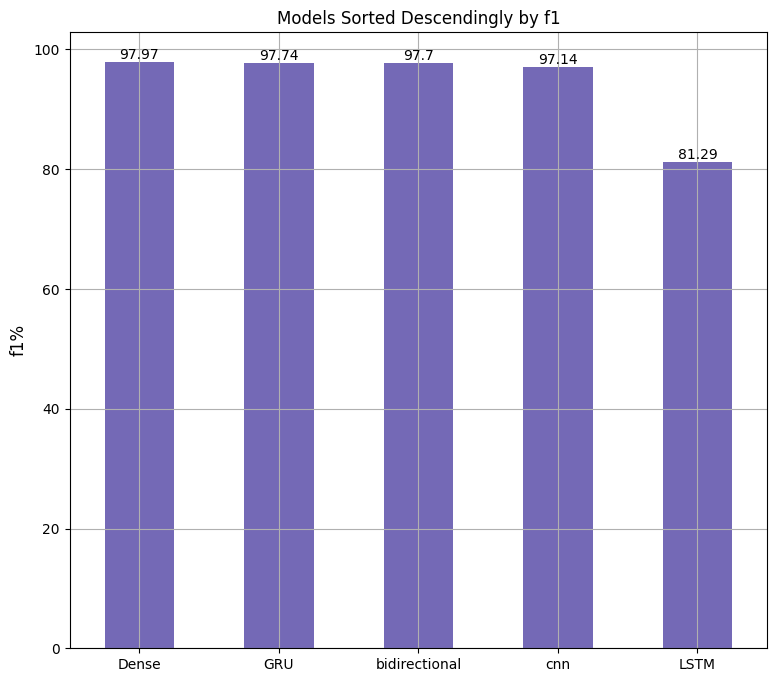

In [170]:
# Plotting bar plot for models sorted descendingly by F1 score 

plot_bar_plot_of_metric('f1','7469B6')

## Comparing prediction time for models 

In [172]:
# fix
# convert test_text to pandas dataframe
test_text_df = pd.DataFrame(test_text, columns=["text"])

In [174]:
# taking a sample of messages 
messages_sample=test_text_df.sample(30)


In [175]:
# creating a function to caculate average prediction time for a model 
import time 

def calculate_pred_time(model: tf.keras.Model,sample: pd.Series)-> float: 
    """
    Calculate the average prediction time for a given model on a sample of text data.

    Parameters:
    model (tf.keras.Model): The trained Keras model used for prediction.
    sample (list): A list of text samples to be used for prediction.

    Returns:
    float: The average prediction time per sample in seconds.
    """
    start=time.time()
    lstm_model_1.predict(messages_sample)
    
    end=time.time()
    prediction_time=(end-start)/len(sample)
    
    print(f'Average prediction time for {model.name} for a message of this sample \n',prediction_time)

In [176]:
calculate_pred_time(lstm_model_1,messages_sample)


1/1 [==============================] - 1s 815ms/step
Average prediction time for lstm_model_1 for a message of this sample 
 0.02965855598449707


In [177]:
calculate_pred_time(gru_model,messages_sample)


1/1 [==============================] - 0s 115ms/step
Average prediction time for GRU_model for a message of this sample 
 0.005794048309326172


In [178]:
calculate_pred_time(cnn_model,messages_sample)


1/1 [==============================] - 0s 122ms/step
Average prediction time for Conv1D_model for a message of this sample 
 0.007417726516723633


In [179]:
calculate_pred_time(bidirectonal_model,messages_sample)


1/1 [==============================] - 0s 147ms/step
Average prediction time for model_4_Bidirectional for a message of this sample 
 0.006884344418843587


In [180]:
calculate_pred_time(dense_model,messages_sample)


1/1 [==============================] - 0s 116ms/step
Average prediction time for dense_model for a message of this sample 
 0.006166521708170573


## Finding wrong predictions with heighest prediction probablities 

In [181]:
# getting predictions from gru model for test_text 
predicted_labels_gru_model=gru_model.predict(test_text)
predicted_labels_gru_model

94/94 [==============================] - 8s 84ms/step


array([[2.3860949e-04],
       [9.9999857e-01],
       [9.9999452e-01],
       ...,
       [9.9999022e-01],
       [9.9999988e-01],
       [9.9297732e-01]], dtype=float32)

In [182]:
# shape of predicted lables 
predicted_labels_gru_model.shape

(3001, 1)

In [183]:
# taking mean of predicted labels 
avg_predicted_labels_gru = np.mean(predicted_labels_gru_model, axis=1)
avg_predicted_labels_gru.shape

(3001,)

In [184]:
# reshaping avg_predicted_labels_gru of shape (2994, 1) to shape (2994, ) and converting it to a list  
avg_predicted_labels_gru=list(avg_predicted_labels_gru.reshape(-1,))

In [186]:
# making dataframe of predicted probabilities
predicted_probs_df=pd.DataFrame({'probability':avg_predicted_labels_gru},index=test_text_df.index)
predicted_probs_df

,probability
0,0.000239
1,0.999999
2,0.999995
3,0.000238
4,0.047800
...,...
2996,0.999943
2997,0.999991
2998,0.999990
2999,1.000000


In [187]:
# checkin gfor column probability type to round it 
predicted_probs_df.dtypes

probability    float32
dtype: object

In [188]:
# creating column pred_labels by rounding coulmn probability using round function 
predicted_probs_df['pred_labels']=predicted_probs_df['probability'].apply(lambda x: round(x))
predicted_probs_df

,probability,pred_labels
0,0.000239,0
1,0.999999,1
2,0.999995,1
3,0.000238,0
4,0.047800,0
...,...,...
2996,0.999943,1
2997,0.999991,1
2998,0.999990,1
2999,1.000000,1


In [189]:
test_text

array(['Once upon a time, Brian wrote :\n\n>     Yeah, I need to work this out, too; I just learned my lesson about\n>     living on the bleeding edge. Lesson learned?  NO MORE XIMIAN, UNDER\n>     ANY CIRCUMSTANCES.  Man, that was annoying.\n\nWe all learned that sooner or later, right? When I got down to that myself\nis when I started redhat.aldil.org, now known as freshrpms.net ;-)\n\n>     Anyway, I have returned to Redhat 7.3 on my root filesystem (saved my\n>     home directories, music and games on other partitions) and while I\n>     have the 8.0 stuff in the list, everything I want to upgrade requires\n>     200+ RPMs.\n> \n>     I\'m not opposed to this, but apt is.  "apt-get dist-upgrade" dumps\n>     core.\n\nStrange.\nAnyway, although I\'d easily recommend upgrading 7.x to 7.3 using apt, I\nwouldn\'t for 7.x to 8.0 as they are C++ binary incompatible... and apt is\nentirely written in C++ and dynamically linked :-/\n\nStill, that doesn\'t explain a core dump :-(\n\n>     W

In [190]:
test_labels

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [194]:
# another fix
# convert test labels to pandas dataframe
test_labels_df = pd.DataFrame(test_labels, columns=["label"])

In [195]:
# making dataframe of test_text and test_labels 
test_df=pd.concat([test_text_df,test_labels_df],axis=1)
test_df

,text,label
0,"Once upon a time, Brian wrote :\n\n> Yeah,...",0
1,Business project\n\n From Mr.Qin Wang\nLloyds ...,1
2,Dear business client of Regions Bank : The Reg...,1
3,"URL: http://www.newsisfree.com/click/-4,805285...",0
4,"Hallo Xxxxxxxxx Yyyyyyy,\n\ndiesen Monat im Ne...",0
...,...,...
2996,Foreclosure World's Premium Moving Source\n\n\...,1
2997,FROM. The Desk OF: DR. RICHARD AKUEZE\nDIRECTO...,1
2998,FROM THE CHAIRMAN\nMR WILLIAM KAMARA\nJOINT RE...,1
2999,--_ccc3f0dd-60da-40fc-a60d-843a5d183942_\nCont...,1


In [196]:
# concatinating test_df and predicted_probs_df 
test_predictions_df=pd.concat([test_df,predicted_probs_df],axis=1)
test_predictions_df

,text,label,probability,pred_labels
0,"Once upon a time, Brian wrote :\n\n> Yeah,...",0,0.000239,0
1,Business project\n\n From Mr.Qin Wang\nLloyds ...,1,0.999999,1
2,Dear business client of Regions Bank : The Reg...,1,0.999995,1
3,"URL: http://www.newsisfree.com/click/-4,805285...",0,0.000238,0
4,"Hallo Xxxxxxxxx Yyyyyyy,\n\ndiesen Monat im Ne...",0,0.047800,0
...,...,...,...,...
2996,Foreclosure World's Premium Moving Source\n\n\...,1,0.999943,1
2997,FROM. The Desk OF: DR. RICHARD AKUEZE\nDIRECTO...,1,0.999991,1
2998,FROM THE CHAIRMAN\nMR WILLIAM KAMARA\nJOINT RE...,1,0.999990,1
2999,--_ccc3f0dd-60da-40fc-a60d-843a5d183942_\nCont...,1,1.000000,1


In [197]:
# renaming columns 
test_predictions_df=test_predictions_df.rename(columns={'phishing':'actual','probability':'predicted_probablity'})


In [198]:
test_predictions_df

,text,label,predicted_probablity,pred_labels
0,"Once upon a time, Brian wrote :\n\n> Yeah,...",0,0.000239,0
1,Business project\n\n From Mr.Qin Wang\nLloyds ...,1,0.999999,1
2,Dear business client of Regions Bank : The Reg...,1,0.999995,1
3,"URL: http://www.newsisfree.com/click/-4,805285...",0,0.000238,0
4,"Hallo Xxxxxxxxx Yyyyyyy,\n\ndiesen Monat im Ne...",0,0.047800,0
...,...,...,...,...
2996,Foreclosure World's Premium Moving Source\n\n\...,1,0.999943,1
2997,FROM. The Desk OF: DR. RICHARD AKUEZE\nDIRECTO...,1,0.999991,1
2998,FROM THE CHAIRMAN\nMR WILLIAM KAMARA\nJOINT RE...,1,0.999990,1
2999,--_ccc3f0dd-60da-40fc-a60d-843a5d183942_\nCont...,1,1.000000,1


In [199]:
# getting a dataframe of messages that  their predicted_labels are  wrong 
mistake_df=test_predictions_df[test_predictions_df['actual']!=test_predictions_df['pred_labels']]

KeyError: 'actual'

In [200]:
# how many messages their predicted_labels are  wrong of test_text
print(f'there are {len(mistake_df)} mestakes in precdiction for this model')

NameError: name 'mistake_df' is not defined

In [ ]:
# sorting  mistake_df descindingly 
mistake_df.sort_values(by='predicted_probablity',ascending=False)

In [ ]:
# splitting false_positives to a dataframe  
false_positives=mistake_df[mistake_df['pred_labels']==1]

# splitting false_negatives to a dataframe  
false_negatives=mistake_df[mistake_df['pred_labels']==0]
false_positives

In [ ]:
# how many false_positives
print(f'there are {len(false_positives)} false positive messages')

In [ ]:
# sorting false_positives descending by predicted_probablity
false_positives.sort_values(by='predicted_probablity',ascending=False)

### Testing  False Positives 

In [ ]:
# taking highest 15 prediction probablities from false_negatives 
highest_prob_false_positives=false_positives.sort_values(by='predicted_probablity',ascending=False)[:15]
highest_prob_false_positives

In [ ]:
highest_prob_false_positives_text=highest_prob_false_positives['text'].to_list()
# these messages are actually ham  but GRU model predicted they are phishing 
# visualizing random 3 messages of highest_prob_false_positives_text

for m in random.sample(highest_prob_false_positives_text,3): 
    print(m,'\n\n','#'*100)

#### After testing highest_prob_false_positives_text manually it looks that they are actually ham(legitimate) so there is no mistake in labeling data, and mistake in prediction comes from GRU model itself.  

### Testing False Negatives

In [ ]:
false_negatives 

In [ ]:
# how many false_negatives

len(false_negatives)

In [ ]:
# sorting false_negatives ascending by predicted_probablity

false_negatives.sort_values(by='predicted_probablity',ascending=True)

In [ ]:
# taking lowest 31 prediction probablities from false_negatives 
lowest_prob_false_negatives=false_negatives.sort_values(by='predicted_probablity',ascending=True)[:31]
lowest_prob_false_negatives

In [ ]:
lowest_prob_false_negatives_text=lowest_prob_false_negatives['text'].to_list()
# these messages are actually phishing but GRU model predicted they are ham 
# visualizing random 3 messages of lowest_prob_false_negatives_text
for m in random.sample(lowest_prob_false_negatives_text,3): 
    print(m,'\n\n','#'*100)

#### After manually testing lowest_prob_false_negatives_text, it appears that these messages are actually spam, not phishing. This issue comes from an error made by the data collectors, who mistakenly mixed some spam messages with phishing messages. These messages should not have been added to the datasets. they are spam and were added to phishing data so they were labeled as phishing .


## 